Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=0 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN                 Vanuatu -15.376700   
262                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
245                           NaN             Timor-Leste  -8.874217   
246                           NaN                    Togo   8.619500   
247                           NaN     Trinidad and Tobago  10.691800   
248                           NaN                 Tunisia  33.886917   
249                           NaN                  Turkey  38.963700   
250                           NaN           United States  40.000000   
251                           NaN                  Uganda   1.373333   
252                           NaN                 Ukraine  48.379400   
253                           NaN    United Arab Emirates  23.424076   
254                      Anguilla          United Kingdom  18.220600   
255                       Bermuda          United Kingdom  32.307800   
256        British Virgin Islands          United Kingdom  18.420700   
257                Cayman Islands          United Kingdom  19.313300   
258               Channel Islands          United Kingdom  49.372300   
259   Falkland Islands (Malvinas)          United Kingdom -51.796300   
260                     Gibraltar          United Kingdom  36.140800   
261                   Isle of Man          United Kingdom  54.236100   
262                    Montserrat          United Kingdom  16.742498   
263      Turks and Caicos Islands          United Kingdom  21.694000   
264                           NaN          United Kingdom  55.378100   
265                           NaN                 Uruguay -32.522800   
266                           NaN              Uzbekistan  41.377491   
267                           NaN                 Vanuatu -15.376700   
268                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/11/20  \
185        0        0        0        0        0        0  ...      1950   
186        0        0        0        0        0        0  ...         2   
187        0        0        0        0        0        0  ...         0   
188        0        0        0        0        0        0  ...       356   
189        0        0        0        0        0        0  ...      4506   
190        0        0        0        0        0        0  ...       104   
191        0        0        0        0        0        0  ...       134   
192        0        0        0        0        0        0  ...      1174   
193        0        0        0        0        0        0  ...        43   
194        0        0        0        0        0        0  ...         3   

     11/12/20  11/13/20  11/14/20  11/15/20  11/16/20  11/17/20  11/18/20  \
185      1969      1987      2006      2019      2035      2054      2072   
186         2         2         2         2         2         3         3   
187         0         0         0         0         0         0         0   
188       364       377       385       391       396       405       414   
189      4570      4631      4697      4779      4850      4932      5013   
190       104       110       110       113       116       118       119   
191       135       138       138       138       138       140       140   
192      1189      1202      1215      1221      1230      1247      1259   
193        43        43        44        44        44        44        45   
194         3         3         3         3         3         3         3   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 308 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/11/20  \
175        0        0        0        0        0        0  ...     11959   
176        0        0        0        0        0        0  ...     11739   
177        0        0        0        0        0        0  ...    162243   
178        0        0        0        0        0        0  ...      4419   
179        0        0        0        0        0        0  ...       145   
180        0        0        0        0        0        0  ...       865   
181        0        0        0        0        0        0  ...       817   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      1913   
184        0        0        0        0        0        0  ...      4225   

     11/12/20  11/13/20  11/14/20  11/15/20  11/16/20  11/17/20  11/18/20  \
175     12134     12238     12505     12505     12599     12646     12754   
176     12188     12243     12467     12680     12843     13140     13152   
177    164592    168129    170632    173430    176364    179242    182780   
178      4497      4511      4521      4534      4535      4547      4558   
179       151       151       151       151       151       151       151   
180       899       913       923       928       945       946       953   
181       825       835       835       835       857       867       874   
182         0         0         0         0         0         0         0   
183      1917      1918      1918      1918      1919      1919      1948   
184      4225      4225      4225      4225      4225      4225      4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 308 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/11/20  \
185        0        0        0        0        0        0  ...     84707   
186        0        0        0        0        0        0  ...       524   
187        0        0        0        0        0        0  ...       406   
188        0        0        0        0        0        0  ...     24865   
189        0        0        0        0        0        0  ...    270626   
190        0        0        0        0        0        0  ...     13991   
191        0        0        0        0        0        0  ...     13292   
192        0        0        0        1        1        1  ...    202329   
193        0        0        0        0        0        0  ...      4631   
194        0        0        0        0        0        0  ...       154   

     11/12/20  11/13/20  11/14/20  11/15/20  11/16/20  11/17/20  11/18/20  \
185     86038     87361     88772     89279     89843     90912     92519   
186       532       540       545       548       552       557       565   
187       412       416       428       431       434       455       505   
188     25509     26109     26686     27177     27773     28392     29031   
189    276821    282336    288211    293177    296189    301604    306995   
190     14094     14227     14340     14448     14514     14566     14629   
191     13345     13372     13449     13508     13555     13566     13610   
192    204242    206353    208299    209776    210973    211475    212917   
193      4639      4650      4658      4662      4668      4676      4685   
194       155       155       155       155       155       157       157   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 308 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State         Country/Region        Lat        Long  1/22/20  \
220            NaN             San Marino  43.942400   12.457800        0   
221            NaN  Sao Tome and Principe   0.186400    6.613100        0   
222            NaN           Saudi Arabia  23.885942   45.079162        0   
223            NaN                Senegal  14.497400  -14.452400        0   
224            NaN                 Serbia  44.016500   21.005900        0   
225            NaN             Seychelles  -4.679600   55.492000        0   
226            NaN           Sierra Leone   8.460555  -11.779889        0   
227            NaN              Singapore   1.283300  103.833300        0   
228            NaN               Slovakia  48.669000   19.699000        0   
229            NaN               Slovenia  46.151200   14.995500        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/11/20  11/12/20  \
220        0        0        0        0        0  ...      1190      1190   
221        0        0        0        0        0  ...       962       963   
222        0        0        0        0        0  ...    351849    352160   
223        0        0        0        0        0  ...     15735     15744   
224        0        0        0        0        0  ...     70424     73765   
225        0        0        0        0        0  ...       158       160   
226        0        0        0        0        0  ...      2386      2387   
227        1        3        3        4        5  ...     58091     58102   
228        0        0        0        0        0  ...     79181     81772   
229        0        0        0        0        0  ...     48939     50870   

     11/13/20  11/14/20  11/15/20  11/16/20  11/17/20  11/18/20   Population   \
220      1253      1253      1253      1290      1290      1358        33,916   
221       963       964       965       965       967       967           NaN   
222    352601    352950    353255    353556    353918    354208    34,695,447   
223     15755     15779     15793     15801     15806     15823           NaN   
224     77264     81086     84568     87381     92375     97988     8,744,671   
225       160       160       160       160       160       160           NaN   
226      2389      2391      2391      2391      2392      2397           NaN   
227     58114     58116     58119     58124     58130     58135     5,612,000   
228     83796     85567     86767     87276     88602     89913     5,459,087   
229     52385     54122     55042     55544     56937     58964     2,078,878   

                        region  
220             San Marino_nan  
221  Sao Tome and Principe_nan  
222           Saudi Arabia_nan  
223                Senegal_nan  
224                 Serbia_nan  
225             Seychelles_nan  
226           Sierra Leone_nan  
227              Singapore_nan  
228               Slovakia_nan  
229               Slovenia_nan  

[10 rows x 308 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

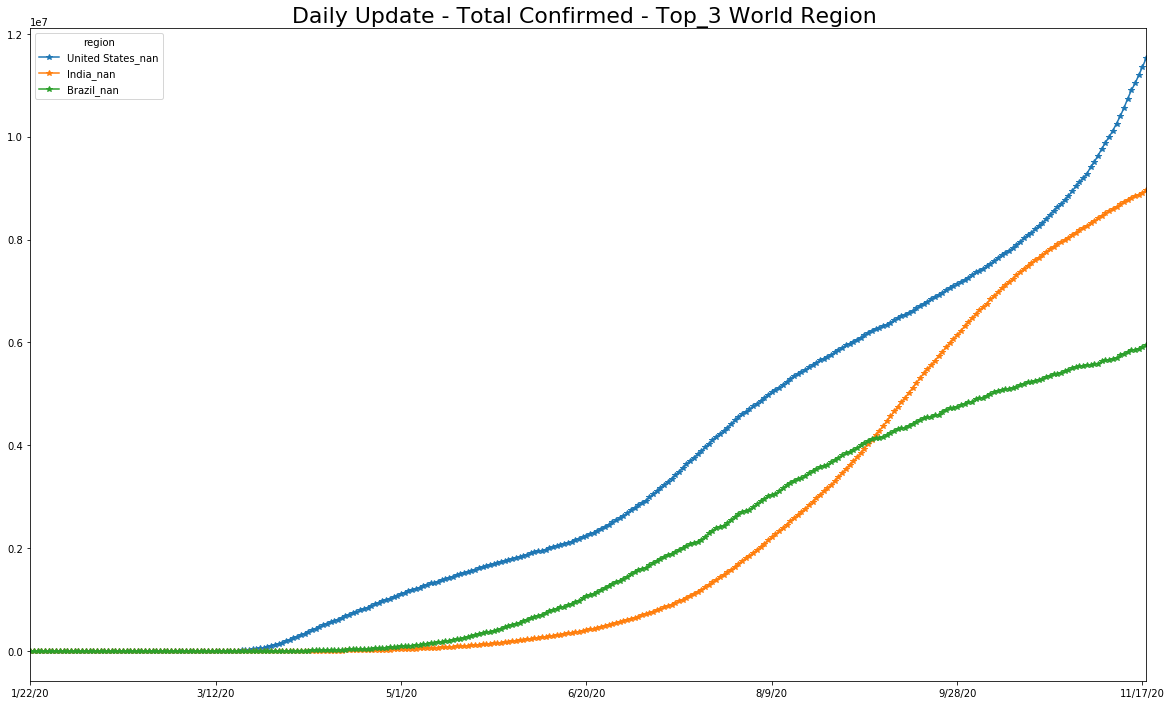

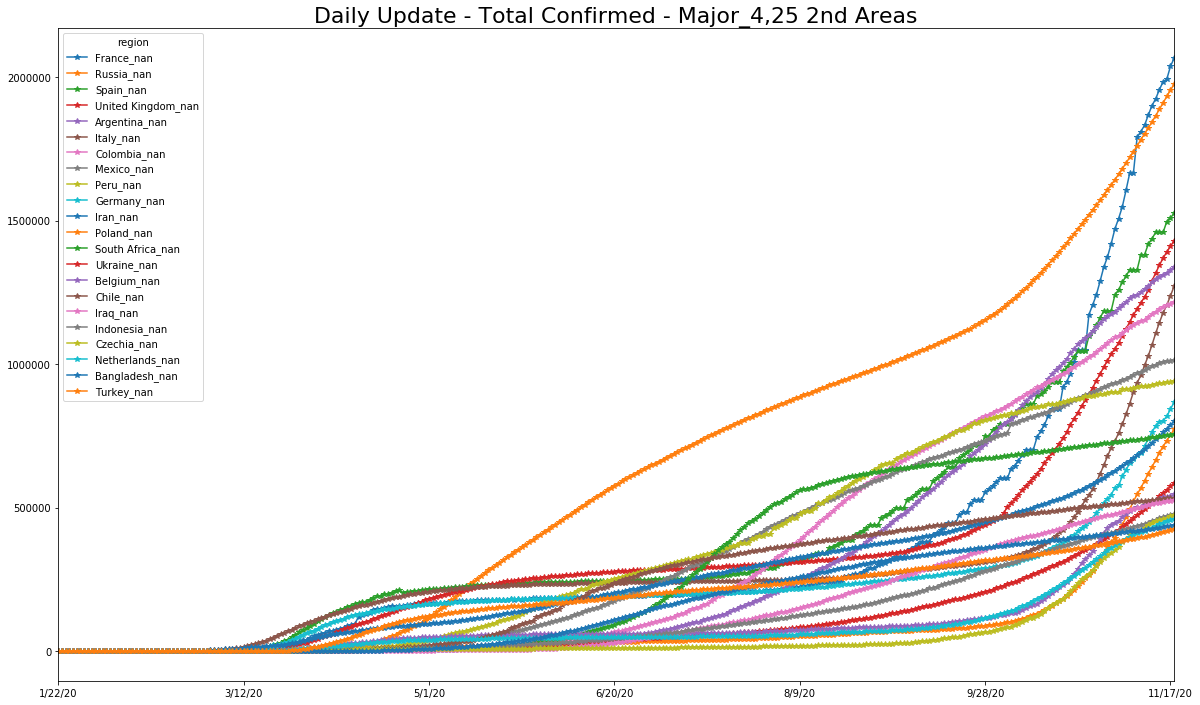

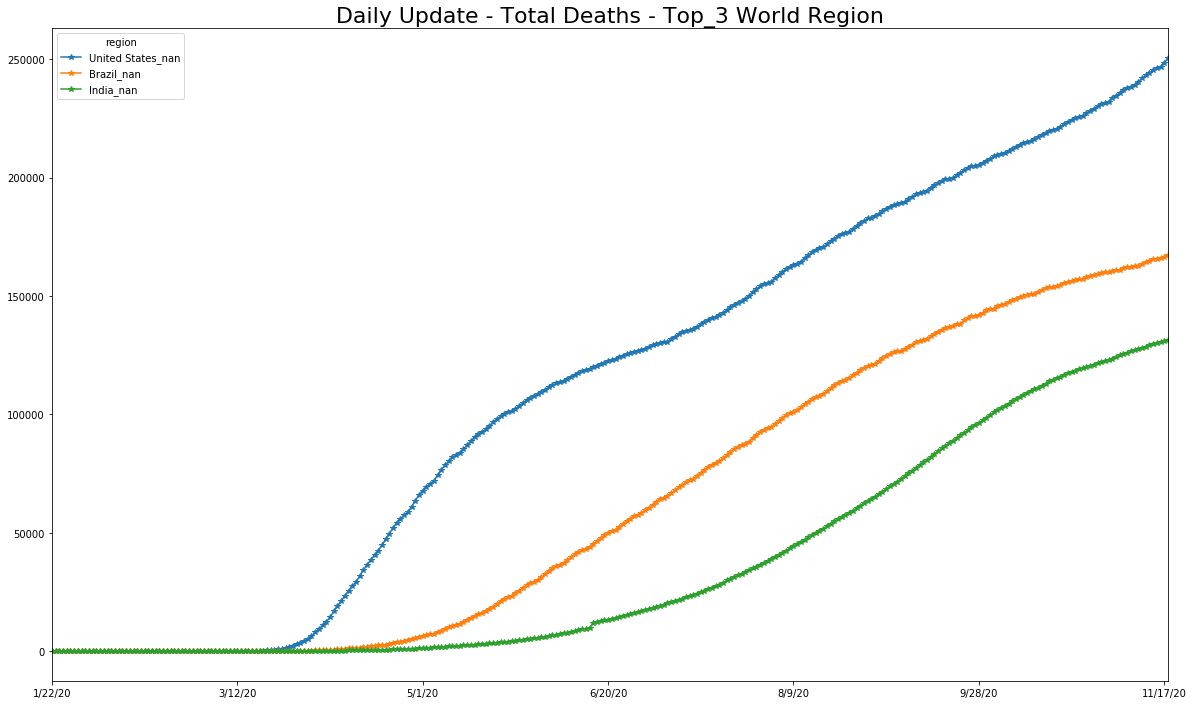

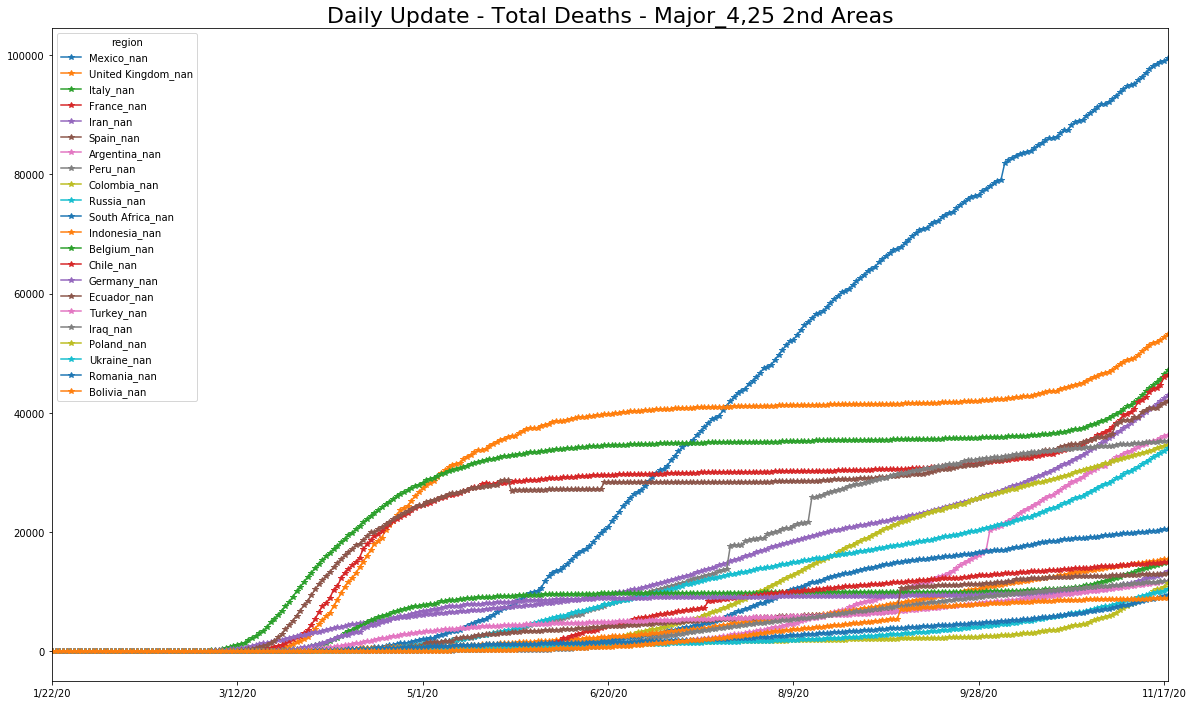

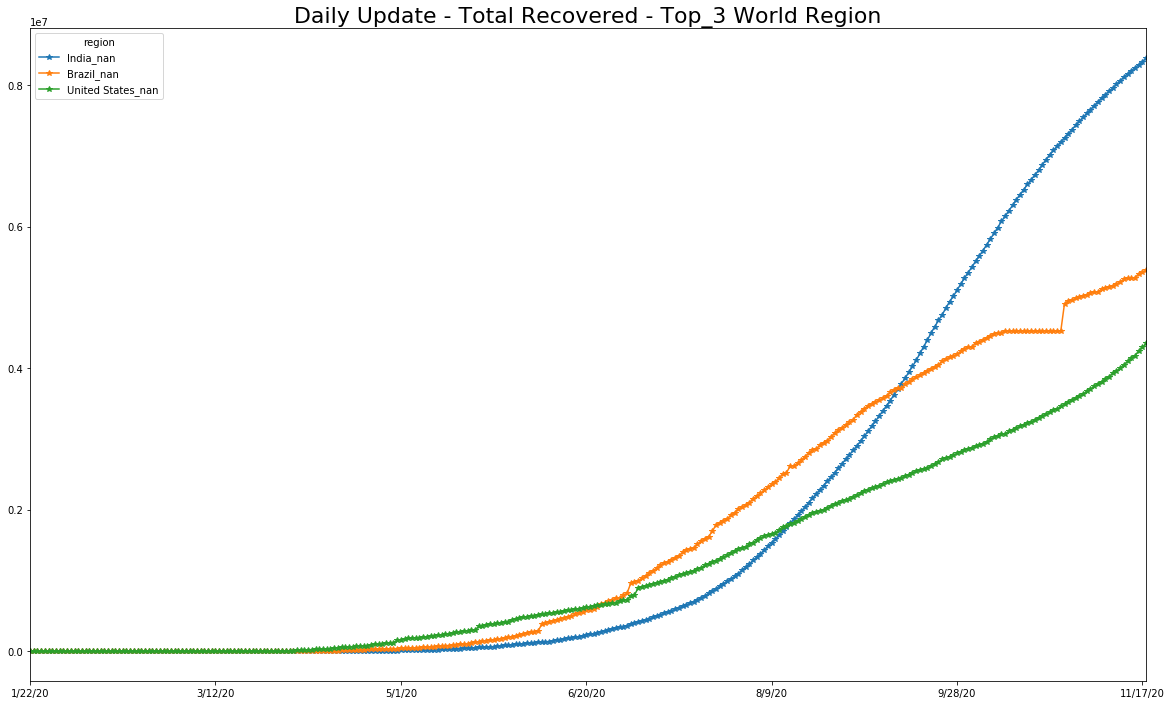

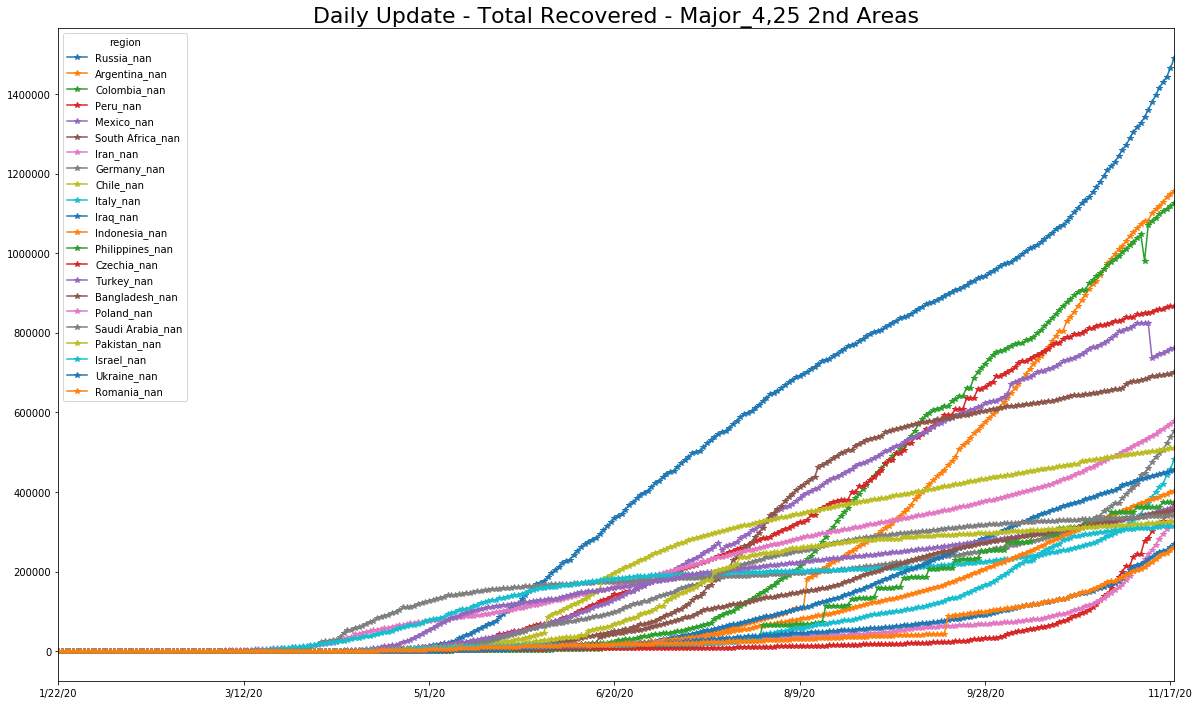

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/19


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

date                     region   min   max
0   2020/11/20  Australia_New South Wales  17.7  26.7
1   2020/11/20                Austria_nan   2.2   3.9
2   2020/11/20                Belgium_nan  10.1  13.9
3   2020/11/20                 Brazil_nan  21.8  22.2
4   2020/11/20             Canada_Ontario  -4.6  -3.5
5   2020/11/20              Canada_Quebec -10.0  -9.0
6   2020/11/20                  Chile_nan  16.0  20.0
7   2020/11/20              China_Beijing   3.0   8.0
8   2020/11/20            China_Guangdong  23.0  31.0
9   2020/11/20            China_Hong Kong  22.2  26.7
10  2020/11/20                China_Hubei  13.0  16.0
11  2020/11/20                China_Macau  23.0  26.0
12  2020/11/20             China_Shanghai  18.9  22.9
13  2020/11/20                Finland_nan   8.0  10.0
14  2020/11/20                 France_nan   9.5  12.9
15  2020/11/20                Germany_nan   8.0  11.0
16  2020/11/20                  India_nan  19.0  29.0
17  2020/11/20                   Iran_nan   6.0  12.0
18  2020/11/20                  Italy_nan   9.0  10.8
19  2020/11/20                  Japan_nan   8.9  19.4
20  2020/11/20           Korea, South_nan  19.0  25.0
21  2020/11/20               Malaysia_nan  24.0  30.0
22  2020/11/20                 Mexico_nan   8.7   8.7
23  2020/11/20            Netherlands_nan  11.7  16.1
24  2020/11/20                 Norway_nan  -3.9   5.0
25  2020/11/20                   Peru_nan  22.8  23.7
26  2020/11/20            Philippines_nan  25.6  29.4
27  2020/11/20                 Poland_nan   7.2   8.3
28  2020/11/20               Portugal_nan  12.4  14.2
29  2020/11/20                 Russia_nan -18.0 -13.0
30  2020/11/20              Singapore_nan  26.5  30.5
31  2020/11/20                  Spain_nan   8.2   9.8
32  2020/11/20                 Sweden_nan  10.6  11.7
33  2020/11/20            Switzerland_nan   6.5   7.3
34  2020/11/20                 Turkey_nan  -0.6   1.0
35  2020/11/20          United States_nan  11.7  11.7
36  2020/11/20         United Kingdom_nan   3.3   6.1

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
7/15/20  ...         1009           14581            0          10428   
7/16/20  ...         1026           15066            0          10854   
7/17/20  ...         1037           15607            0          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 269 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/15/20            43240        27830        67679         5872       13451   
11/16/20            43403        28432        68589         5914       13615   
11/17/20            43628        29126        69591         5951       13818   
11/18/20            43851        29837        70629         6018       13922   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/15/20                      134        1310491       117337   
11/16/20                      134        1318384       117886   
11/17/20                      134        1329005       118870   
11/18/20                      139        1339337       120459   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
11/15/20                                     114                       4498   
11/16/20                                     114                       4502   
11/17/20                                     115                       4509   
11/18/20                                     115                       4514   

region    ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
11/15/20  ...         4030           70243            1          97352   
11/16/20  ...         4104           70381            1          97739   
11/17/20  ...         4208           70648            1          98050   
11/18/20  ...         4296           70858            1          98350   

region    Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/15/20         1281                   63031                  10       2072   
11/16/20         1283                   63867                  10       2078   
11/17/20         1288                   64935                  10       2081   
11/18/20         1300                   66186                  10       2083   

region    Zambia_nan  Zimbabwe_nan  
11/15/20       17123          8829  
11/16/20       17187          8897  
11/17/20       17243          8945  
11/18/20       17280          8981  

[4 rows x 269 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
7491 2020-05-10  Vietnam_nan  26.9  33.0
7492 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
35170 2020-10-21     Zimbabwe_nan       8215            28            77   
35171 2020-10-22     Zimbabwe_nan       8242            28            68   
35172 2020-10-23     Zimbabwe_nan       8257            27            83   
35173 2020-10-24     Zimbabwe_nan       8269            15            70   
35174 2020-10-25     Zimbabwe_nan       8276            12            54   
35175 2020-10-26     Zimbabwe_nan       8303             7            34   
35176 2020-10-27     Zimbabwe_nan       8315            27            46   
35177 2020-10-28     Zimbabwe_nan       8320            12            46   
35178 2020-10-29     Zimbabwe_nan       8349             5            44   
35179 2020-10-30     Zimbabwe_nan       8362            29            46   
35180 2020-10-31     Zimbabwe_nan       8367            13            47   
35181 2020-11-01     Zimbabwe_nan       8374             5            47   
35182 2020-11-02     Zimbabwe_nan       8389             7            25   
35183 2020-11-03     Zimbabwe_nan       8410            15            27   
35184 2020-11-04     Zimbabwe_nan       8427            21            43   
35185 2020-11-05     Zimbabwe_nan       8444            17            53   
35186 2020-11-06     Zimbabwe_nan       8471            17            55   
35187 2020-11-07     Zimbabwe_nan       8498            27            61   
35188 2020-11-08     Zimbabwe_nan       8531            27            71   
35189 2020-11-09     Zimbabwe_nan       8561            33            87   
35190 2020-11-10     Zimbabwe_nan       8610            30  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
35199 2020-11-19  Zimbabwe_nan          0            36           152   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
35199           314         100.402571         101.721713         103.623053   

       last_day  kalman_prediction  population  infected_rate  min  max  
35199      8981             9032.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
35199 2020-11-19  Zimbabwe_nan          0            36           152   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
35199           314         100.402571         101.721713         103.623053   

       last_day  kalman_prediction  population  infected_rate  min  max  
35199      8981             9032.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
34429  2020-11-17  Zimbabwe_nan       8945            68           132   
34430  2020-11-18  Zimbabwe_nan       8981            48           159   
34431  2020-11-19  Zimbabwe_nan          0            36           152   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
34429           336         100.770302         101.506104         103.924892   
34430           335         100.539620         101.809811         103.890941   
34431           314         100.402571         101.721713         103.623053   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
34429                 8897  ...    14862924       0.000006  NaN  NaN   
34430                 8945  ...    14862924       0.000006  NaN  NaN   
34431                 8981  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
34429                                         0.000599   
34430                                         0.000602   
34431                                         0.000604   

       population_percentage : factor 9/10 infected_rate confirmed  \
34429                                           0.005987             
34430                                           0.006019             
34431                                           0.006043             

       delta : new_cases  delta : new_cases per 1M hab  \
34429               35.0                      2.354853   
34430               42.0                      2.825824   
34431               51.0                      3.431357   

       delta : roling 7day AVG  \
34429                48.000000   
34430                47.857143   
34431                44.857143   

       delta : aprox 14-day case notification rate per 100k hab  
34429                                           4.521318         
34430                                           4.507861         
34431                                           4.225279         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
258  United States_nan  1.076223e+12  1.037412e+06  109081.472441


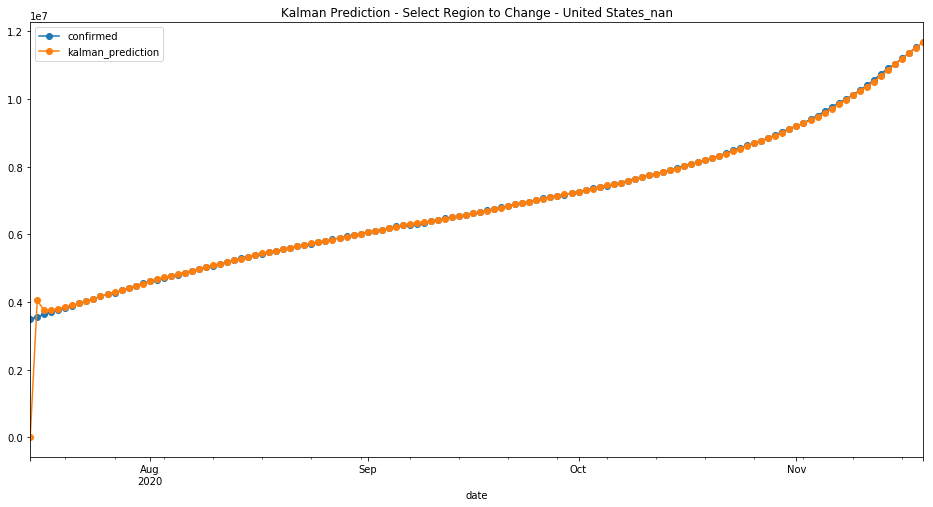

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
209  Russia_nan  3.154044e+10  177596.289945  18066.173228


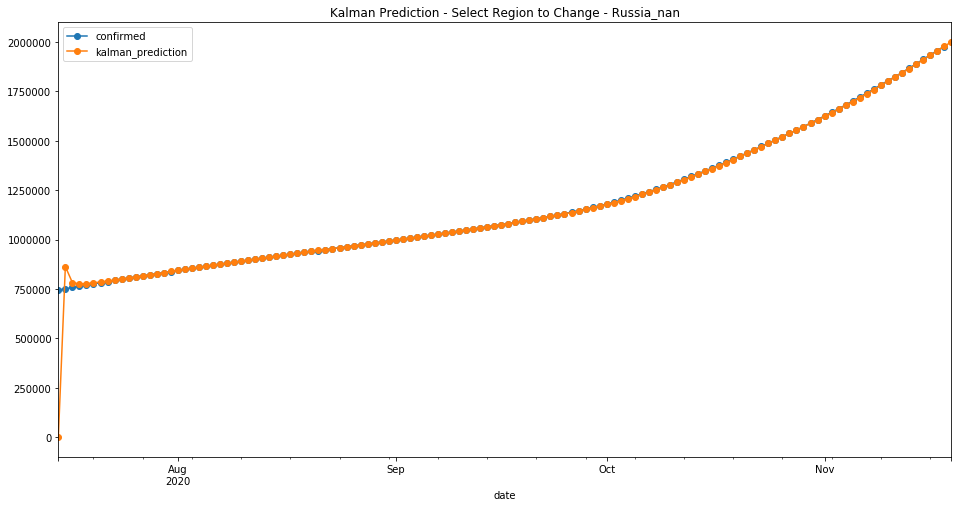

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse          mae
30  Brazil_nan  2.816615e+11  530717.950498  64512.23622


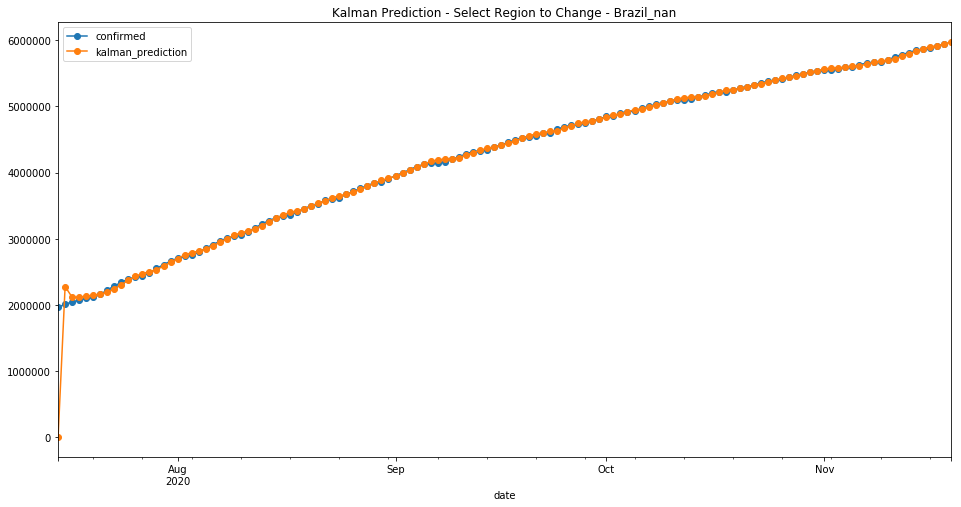

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
257  United Kingdom_nan  1.678240e+10  129546.886988  13962.291339


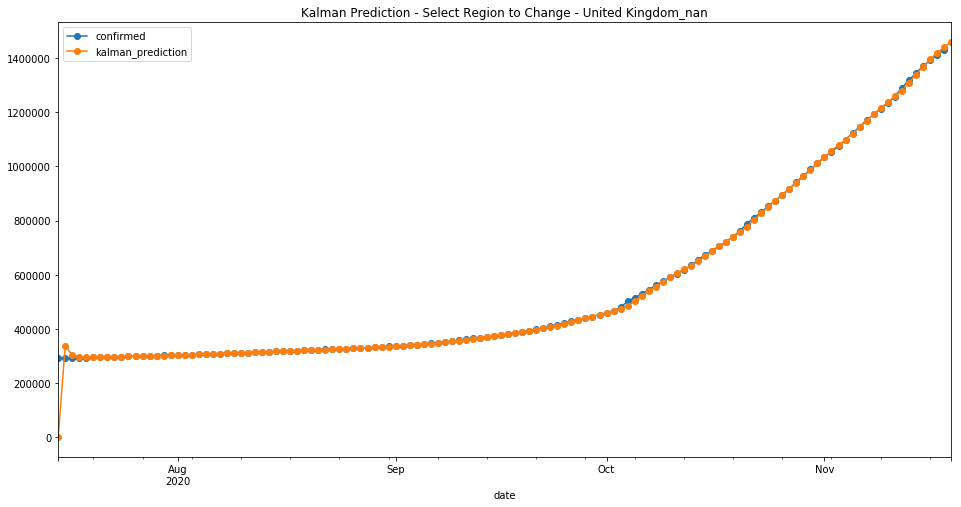

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmu_tz8p_
  JVM stdout: /tmp/tmpmu_tz8p_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmu_tz8p_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 21 days
H2O_cluster_name:           H2O_from_python_unknownUser_75s81t
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-11-11
last_train_date= 2020-11-18
first_bootstrap_date= 2020-11-10
boost_bootstrap_date= 2020-11-15
first_test_date= 2020-11-09
last_test_date= 2020-11-19
first_valid_date= 2020-11-17


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   42425.0      42463 2020-11-10  Afghanistan_nan
1   42597.0      42609 2020-11-11  Afghanistan_nan
2   42769.0      42795 2020-11-12  Afghanistan_nan
3   42963.0      42969 2020-11-13  Afghanistan_nan
4   43162.0      43035 2020-11-14  Afghanistan_nan
5   43292.0      43240 2020-11-15  Afghanistan_nan
6   43461.0      43403 2020-11-16  Afghanistan_nan
7   43632.0      43628 2020-11-17  Afghanistan_nan
8   43839.0      43851 2020-11-18  Afghanistan_nan
9   44069.0          0 2020-11-19  Afghanistan_nan
10  25052.0      25294 2020-11-10      Albania_nan
11  25634.0      25801 2020-11-11      Albania_nan
12  26214.0      26211 2020-11-12      Albania_nan
13  26717.0      26701 2020-11-13      Albania_nan
14  27175.0      27233 2020-11-14      Albania_nan
15  27674.0      27830 2020-11-15      Albania_nan
16  28229.0      28432 2020-11-16      Albania_nan
17  28834.0      29126 2020-11-17      Albania_nan
18  29498.0      29837 2020-11-18      Albania_nan
19  30232.0          0 2020-11-19      Albania_nan
20  63263.0      63446 2020-11-10      Algeria_nan
21  64040.0      64257 2020-11-11      Algeria_nan
22  64875.0      65108 2020-11-12      Algeria_nan
23  65762.0      65975 2020-11-13      Algeria_nan
24  66679.0      66819 2020-11-14      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  74604.0      75688 2020-11-15  Azerbaijan_nan
176  76797.0      77083 2020-11-16  Azerbaijan_nan
177  78533.0      79158 2020-11-17  Azerbaijan_nan
178  80652.0      81397 2020-11-18  Azerbaijan_nan
179  82940.0          0 2020-11-19  Azerbaijan_nan
180   7128.0       7012 2020-11-10     Bahamas_nan
181   7104.0       7060 2020-11-11     Bahamas_nan
182   7150.0       7124 2020-11-12     Bahamas_nan
183   7187.0       7163 2020-11-13     Bahamas_nan
184   7285.0       7163 2020-11-14     Bahamas_nan
185   7366.0       7186 2020-11-15     Bahamas_nan
186   7345.0       7256 2020-11-16     Bahamas_nan
187   7318.0       7312 2020-11-17     Bahamas_nan
188   7403.0       7323 2020-11-18     Bahamas_nan
189   7507.0          0 2020-11-19     Bahamas_nan
190  83561.0      83811 2020-11-10     Bahrain_nan
191  83735.0      84042 2020-11-11     Bahrain_nan
192  83944.0      84192 2020-11-12     Bahrain_nan
193  84101.0      84349 2020-11-13     Bahrain_nan
194  84254.0      84523 2020-11-14     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  108240.0     108300 2020-11-10  Belarus_nan
221  109273.0     109357 2020-11-11  Belarus_nan
222  110328.0     110455 2020-11-12  Belarus_nan
223  111428.0     111622 2020-11-13  Belarus_nan
224  112597.0     112870 2020-11-14  Belarus_nan
225  113852.0     114185 2020-11-15  Belarus_nan
226  115191.0     115448 2020-11-16  Belarus_nan
227  116517.0     116699 2020-11-17  Belarus_nan
228  117835.0     118008 2020-11-18  Belarus_nan
229  119188.0          0 2020-11-19  Belarus_nan
230  513065.0     507475 2020-11-10  Belgium_nan
231  516045.0     515391 2020-11-11  Belgium_nan
232  521942.0     520393 2020-11-12  Belgium_nan
233  525637.0     525012 2020-11-13  Belgium_nan
234  530087.0     531280 2020-11-14  Belgium_nan
235  535651.0     535939 2020-11-15  Belgium_nan
236  540055.0     537871 2020-11-16  Belgium_nan
237  542602.0     540605 2020-11-17  Belgium_nan
238  545180.0     545787 2020-11-18  Belgium_nan
239  549523.0          0 2020-11-19  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2254795094.1882453
# MSE on the validation data =  2304752876052.2524
# R^2 on the training data =  0.9991998882694776
# R^2 on the validation data =  0.44904327359804996


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1605765742920_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           16638992.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.938      2333.0      2714.0     2602.284



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2254795094.1882453
RMSE: 47484.682732311114
MAE: 4276.924626543996
RMSLE: 0.21017068503808478
Mean Residual Deviance: 2254795094.1882453

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 2304752876052.2524
RMSE: 1518141.2569495146
MAE: 394977.5126422202
RMSLE: 7.094538977705976
Mean Residual Deviance: 2304752876052.2524

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-19 06:02:31   0.119 sec              0.0            NaN   
1     2020-11-19 06:02:32   0.603 sec              1.0  117964.036809   
2     2020-11-19 06:02:32   0.811 sec              2.0   91587.230359   
3     2020-11-19 06:02:32   0.946 sec              3.0   86615.323122   
4     2020-11-19 06:02:32   1.079 sec              4.0   79490.667346   
5     2020-11-19 06:02:33   1.294 sec              5.0   77770.764958   
6     2020-11-19 06:02:33   1.389 sec              6.0   67013.847482   
7     2020-11-19 06:02:33   1.467 sec              7.0   64949.289436   
8     2020-11-19 06:02:33   1.579 sec              8.0   63660.952487   
9     2020-11-19 06:02:33   1.656 sec              9.0   61800.157786   
10    2020-11-19 06:02:33   1.733 sec             10.0   56952.481191   
11    2020-11-19 06:02:33   1.807 sec             11.0   55080.095127   
12    2020-11-19 06:02:33   1.909 sec             12.0   54378.742692   
13    2020-11-19 06:02:33   2.013 sec             13.0   53490.478969   
14    2020-11-19 06:02:33   2.131 sec             14.0   51879.259309   
15    2020-11-19 06:02:34   2.280 sec             15.0   51615.756772   
16    2020-11-19 06:02:34   2.402 sec             16.0   53400.245100   
17    2020-11-19 06:02:34   2.472 sec             17.0   52367.283220   
18    2020-11-19 06:02:34   2.538 sec             18.0   51737.792544   
19    2020-11-19 06:02:34   2.613 sec             19.0   51858.539960   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   16105.155512       1.391551e+10     1.377042e+06   405665.739548   
2   12978.221128       8.388221e+09     1.376464e+06   395431.729466   
3   12439.187567       7.502214e+09     1.414792e+06   394056.407669   
4   10792.147389       6.318766e+09     1.436405e+06   393995.561523   
5   10746.662951       6.048292e+09     1.427295e+06   392911.433229   
6   10026.020195       4.490856e+09     1.440872e+06   394632.224184   
7    9719.643361       4.218410e+09     1.453277e+06   393217.326624   
8    9230.288746       4.052717e+09     1.470213e+06   399146.698099   
9    8848.720221       3.819260e+09     1.492711e+06   401511.880449   
10   8264.963562       3.243585e+09     1.496188e+06   399693.458782   
11   7803.767301       3.033817e+09     1.498565e+06   398848.518812   
12   7484.283598       2.957048e+09     1.500953e+06   397978.968607   
13   7184.180152       2.861231e+09     1.503411e+06   397227.978702   
14   6857.860886       2.691458e+09     1.504096e+06   396685.902528   
15   6661.128361       2.664186e+09     1.505716e+06   396039.678273   
16   6688.047962       2.851586e+09     1.507814e+06   395812.132107   
17   6637.094331       2.742332e+09     1.508692e+06   395124.655549   
18   6570.928498       2.676799e+09     1.517334e+06   397862.017109   
19   6593.127952       2.689308e+09     1.517763e+06   397174.117608   

    validation_deviance  
0                   NaN  
1          1.896244e+12  
2          1.894652e+12  
3          2.001635e+12  
4          2.063260e+12  
5          2.037171e+12  
6          2.076111e+12  
7          2.112015e+12  
8          2.161527e+12  
9          2.228187e+12  
10         2.238580e+12  
11         2.245698e+12  
12         2.252858e+12  
13         2.260244e+12  
14         2.262305e+12  
15         2.267182e+12  
16         2.273504e+12  
17         2.276153e+12  
18         2.302302e+12  
19         2.303606e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.499991e+18           1.000000    0.371608
1            last_day         1.885922e+18           0.754371    0.280330
2              region         9.584835e+17           0.383395    0.142472
3        7_day_change         6.606803e+17           0.264273    0.098206
4        3_day_change         2.972985e+17           0.118920    0.044192
5        1_day_change         2.466549e+17           0.098662    0.036664
6       infected_rate         6.798205e+16           0.027193    0.010105
7   7_day_change_rate         4.859494e+16           0.019438    0.007223
8   1_day_change_rate         3.074681e+16           0.012299    0.004570
9   3_day_change_rate         1.963224e+16           0.007853    0.002918
10                max         6.902103e+15           0.002761    0.001026
11                min         4.613215e+15           0.001845    0.000686

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.499991e+18           1.000000    0.371608
1            last_day         1.885922e+18           0.754371    0.280330
2              region         9.584835e+17           0.383395    0.142472
3        7_day_change         6.606803e+17           0.264273    0.098206
4        3_day_change         2.972985e+17           0.118920    0.044192
5        1_day_change         2.466549e+17           0.098662    0.036664
6       infected_rate         6.798205e+16           0.027193    0.010105
7   7_day_change_rate         4.859494e+16           0.019438    0.007223
8   1_day_change_rate         3.074681e+16           0.012299    0.004570
9   3_day_change_rate         1.963224e+16           0.007853    0.002918
10                max         6.902103e+15           0.002761    0.001026
11                min         4.613215e+15           0.001845    0.000686

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


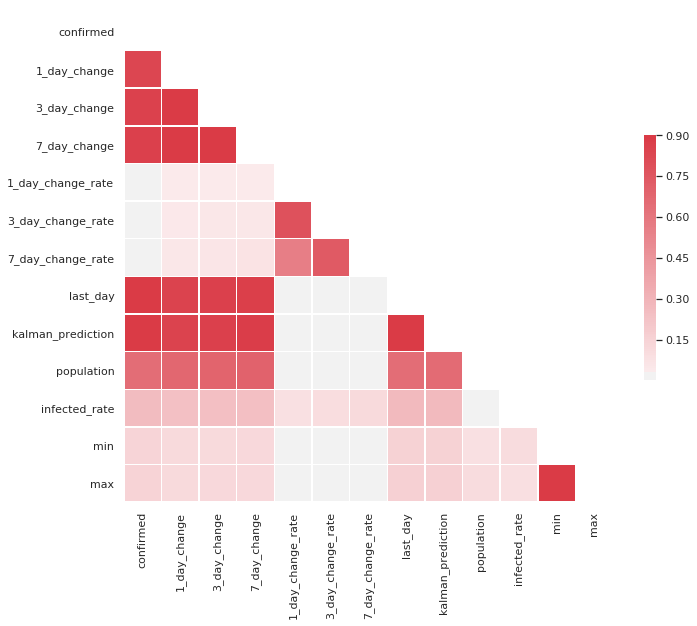

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.837748
3_day_change         0.857047
7_day_change         0.864707
1_day_change_rate    0.023327
3_day_change_rate    0.025555
7_day_change_rate    0.027944
last_day             0.988357
kalman_prediction    0.989082
population           0.650667
infected_rate        0.266178
min                  0.145446
max                  0.152700
Name: confirmed, dtype: float64


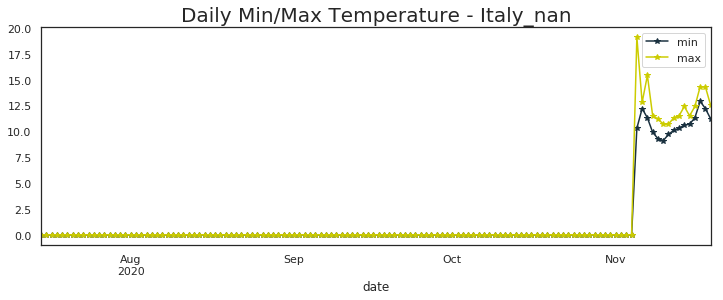

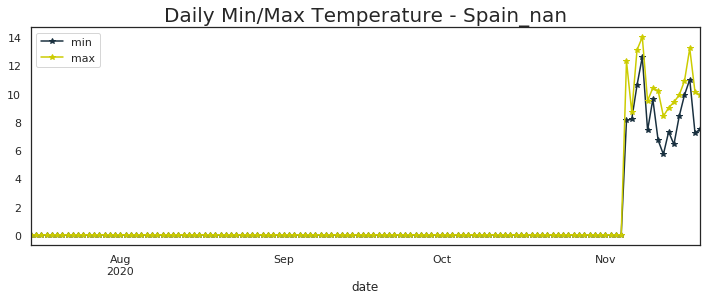

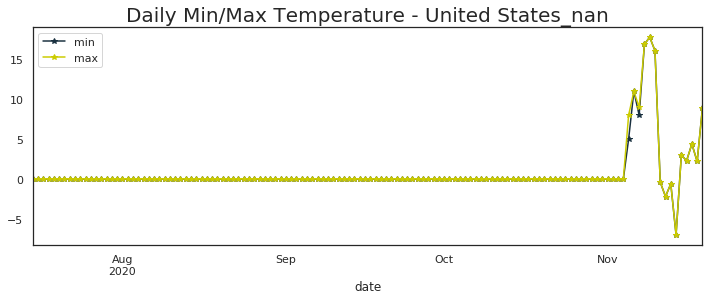

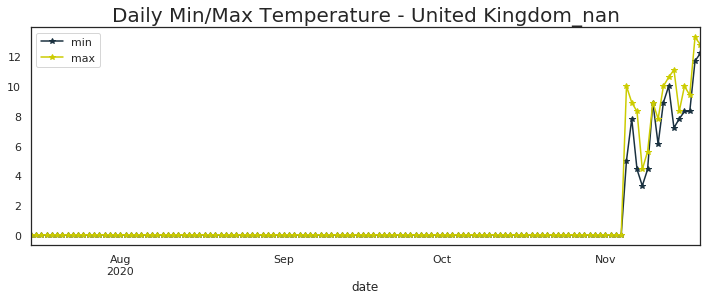

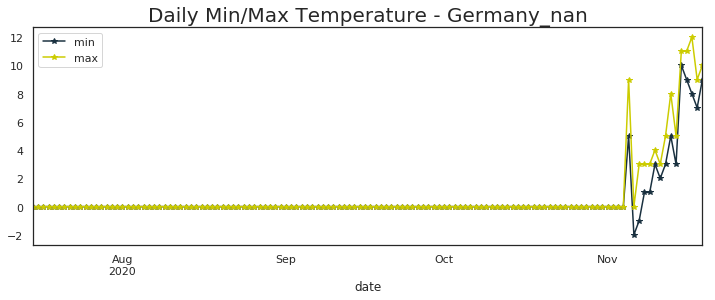

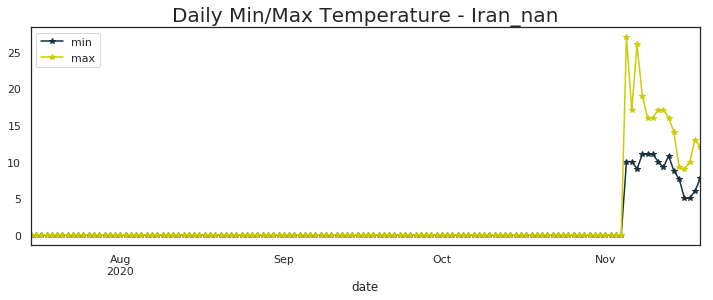

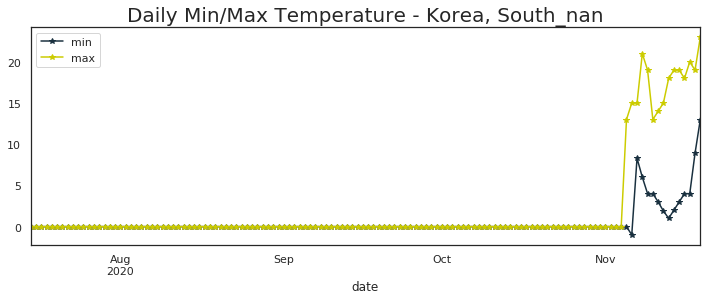

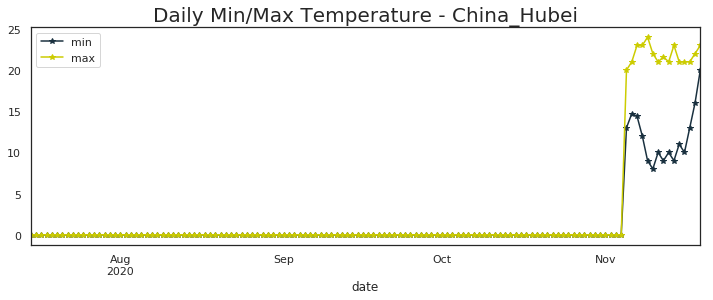

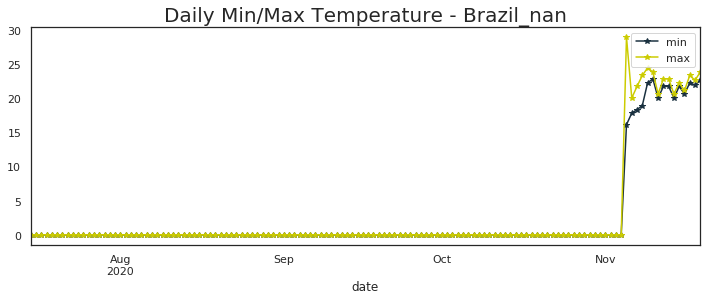

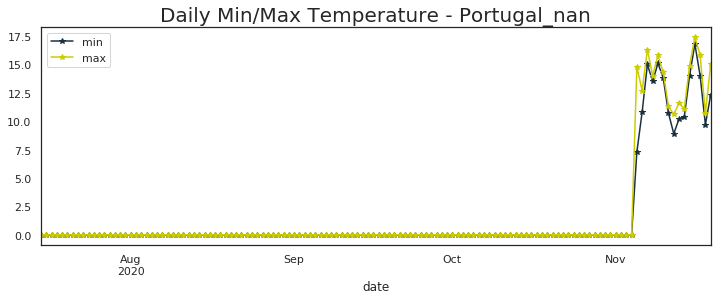

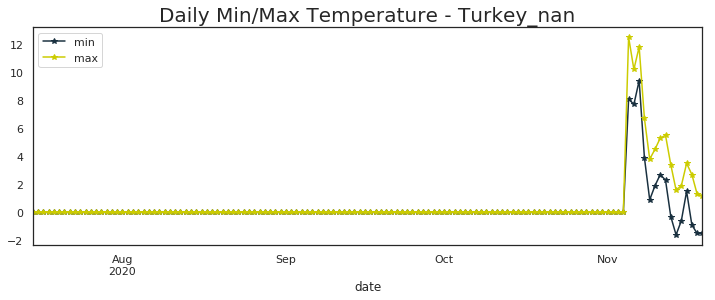

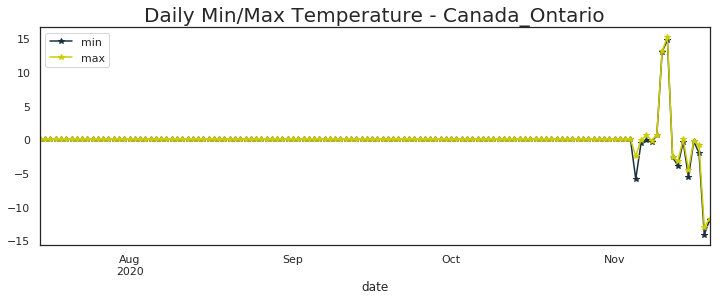

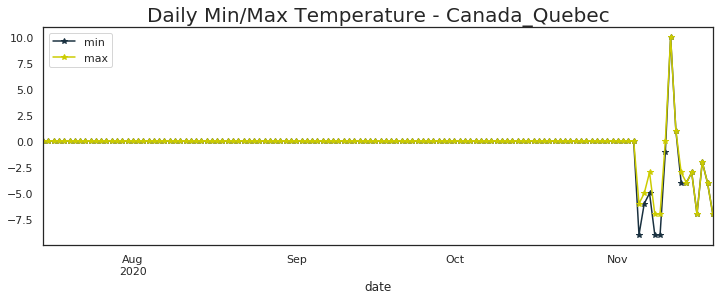

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                          min   max
region                             
United States_nan        17.8  17.8
India_nan                21.0  31.0
Brazil_nan               22.8  28.9
France_nan               12.1  13.3
Russia_nan                0.0   4.0
Spain_nan                12.6  14.0
United Kingdom_nan       12.2  13.3
Argentina_nan             0.0   0.0
Italy_nan                12.9  19.1
Colombia_nan              0.0   0.0
Mexico_nan               15.1  15.1
Peru_nan                 24.6  29.9
Germany_nan              10.0  12.0
Iran_nan                 11.0  27.0
Poland_nan                8.9  10.6
South Africa_nan          0.0   0.0
Ukraine_nan               0.0   0.0
Belgium_nan              13.7  14.5
Chile_nan                17.0  22.0
Iraq_nan                  0.0   0.0
Indonesia_nan             0.0   0.0
Czechia_nan               0.0   0.0
Netherlands_nan          14.4  15.6
Bangladesh_nan            0.0   0.0
Turkey_nan                9.

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

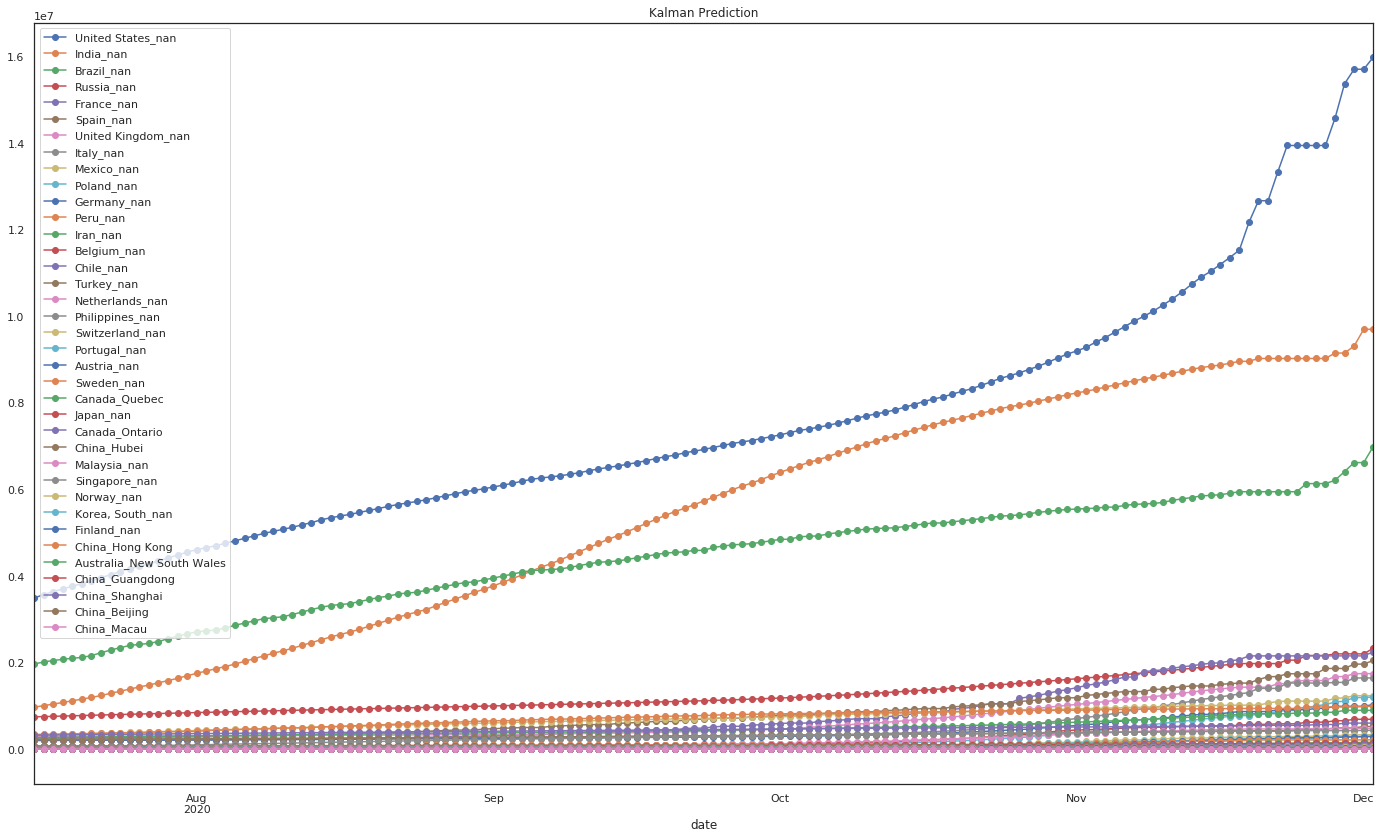

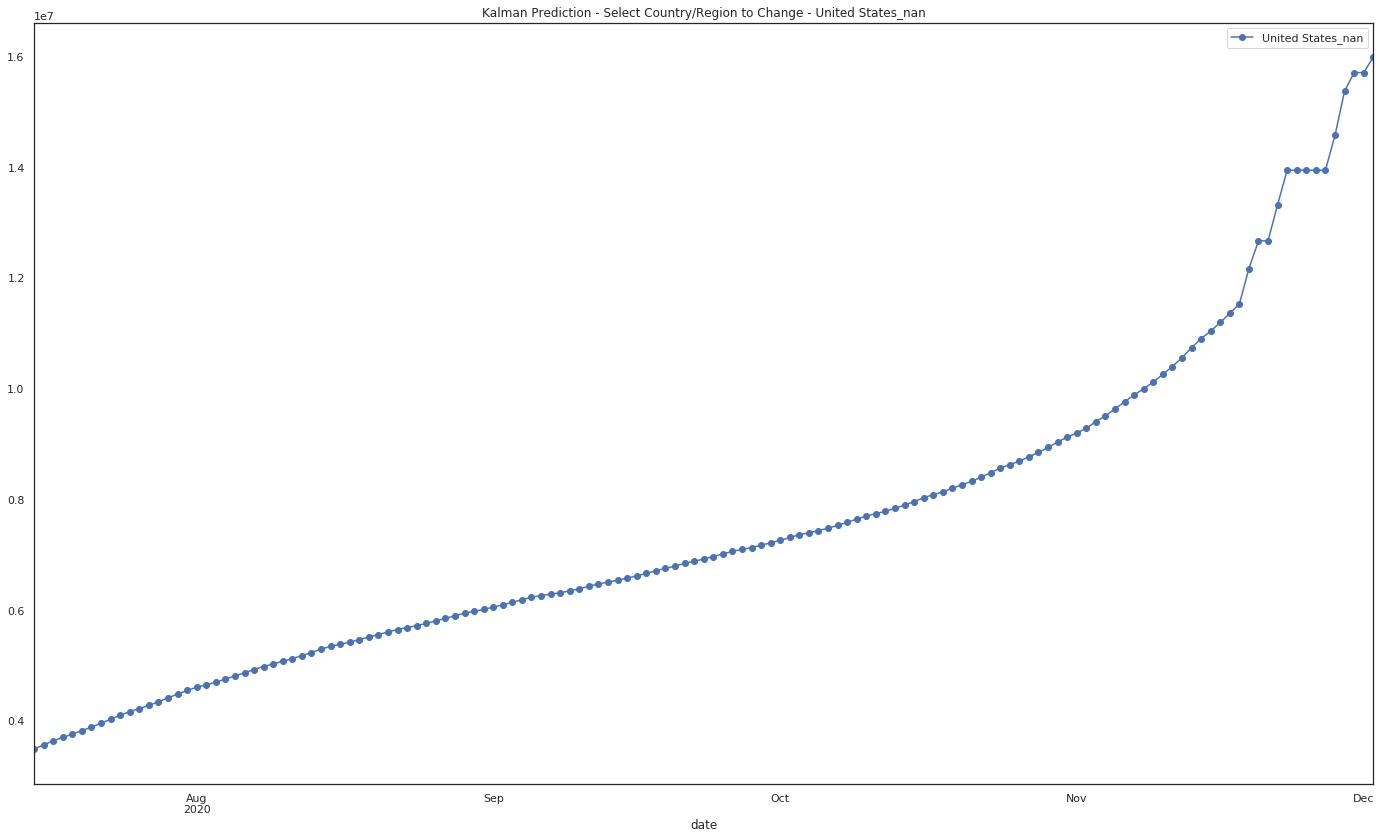

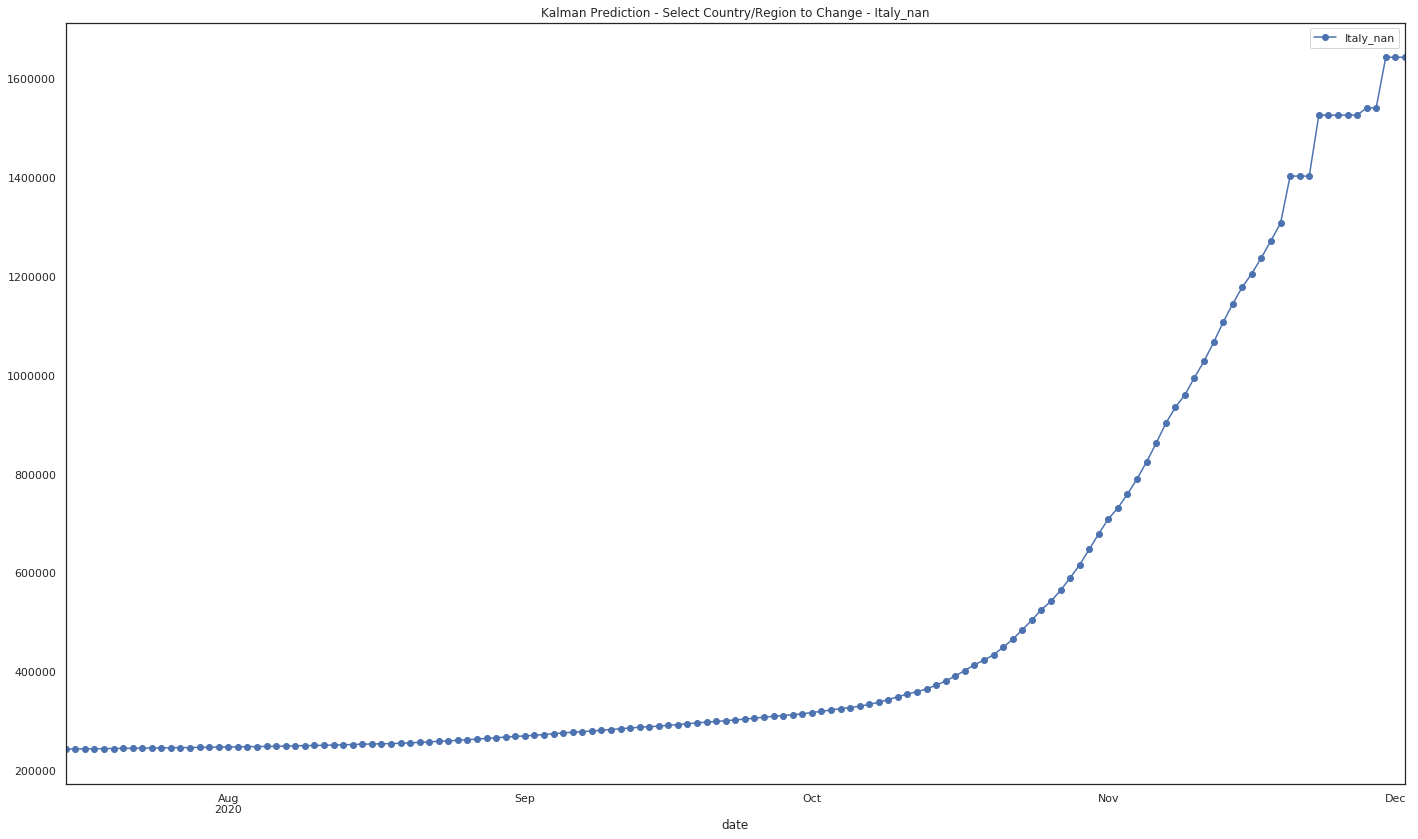

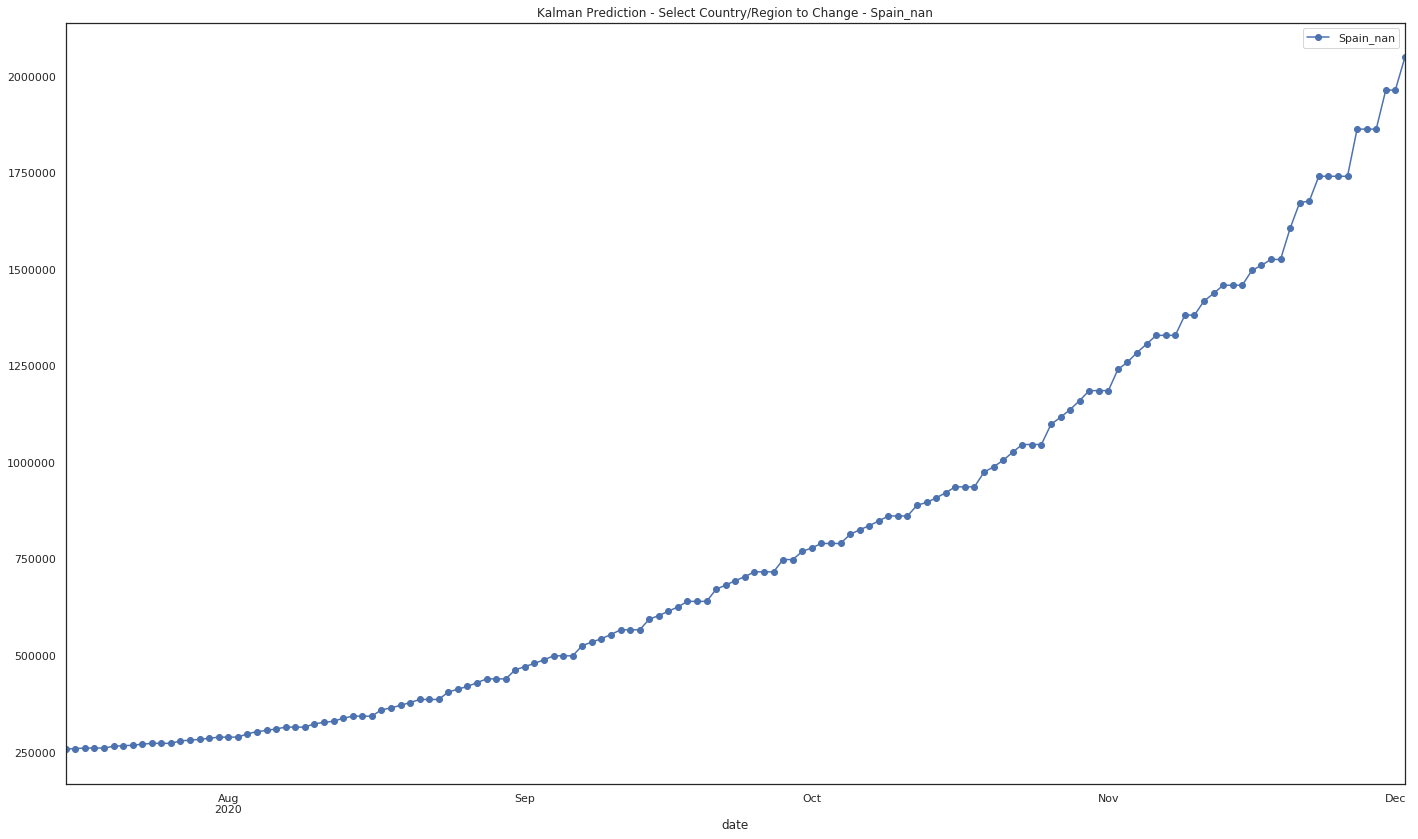

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


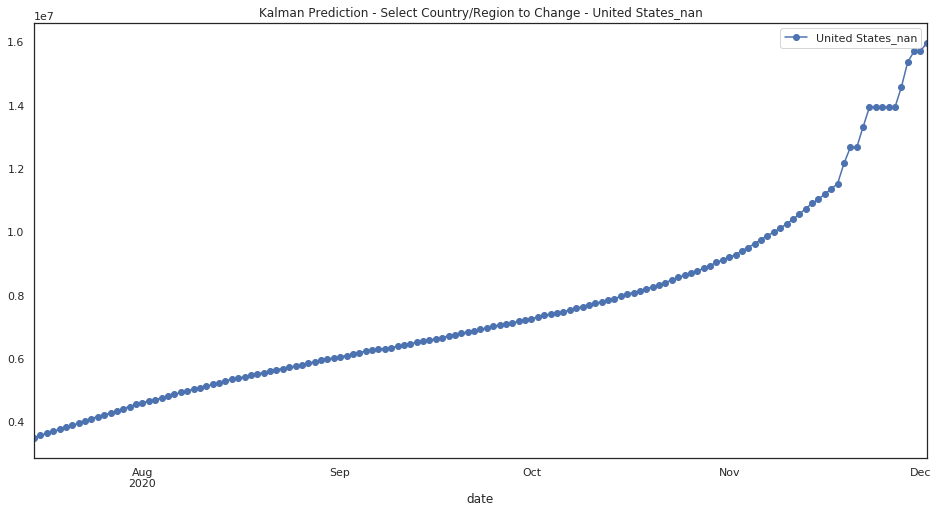

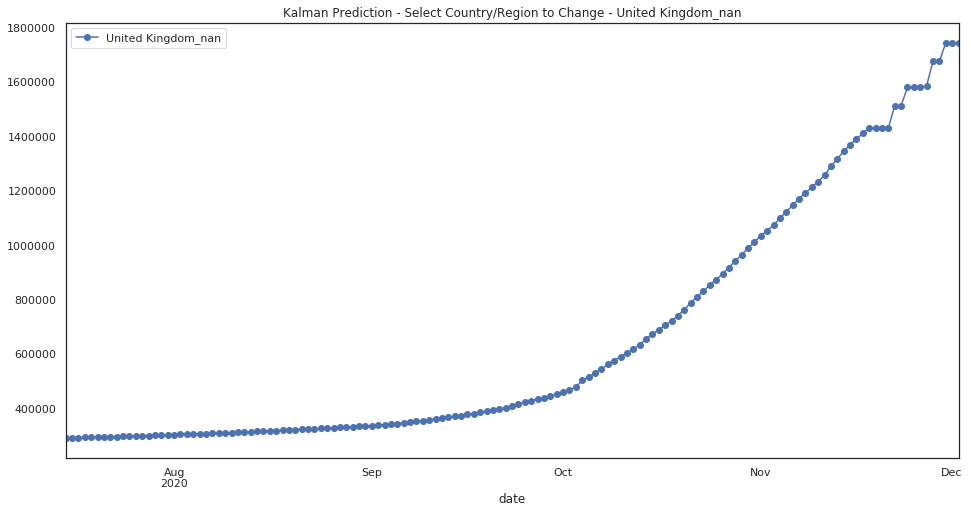

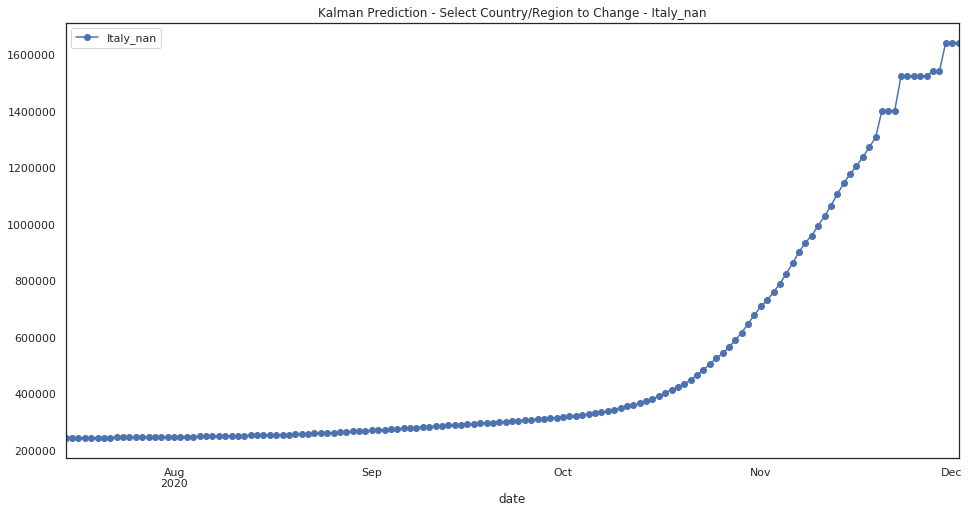

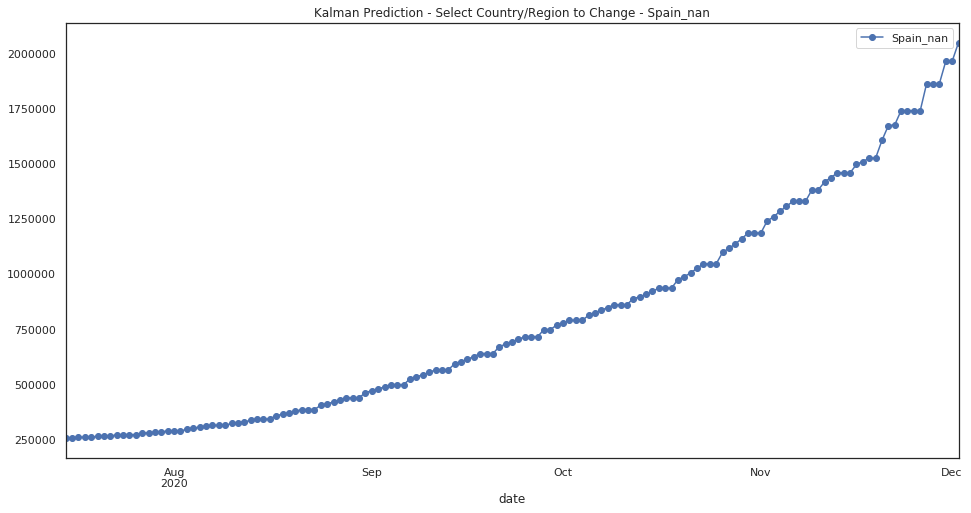

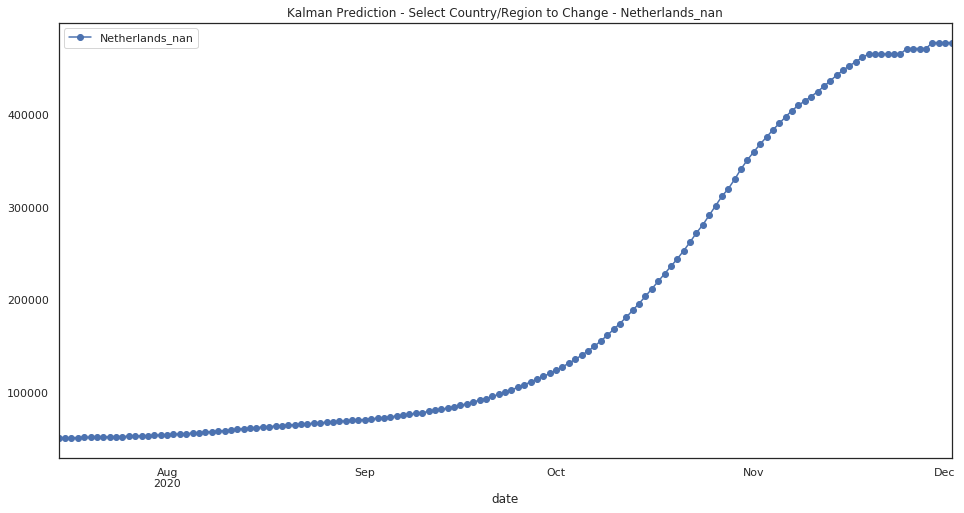

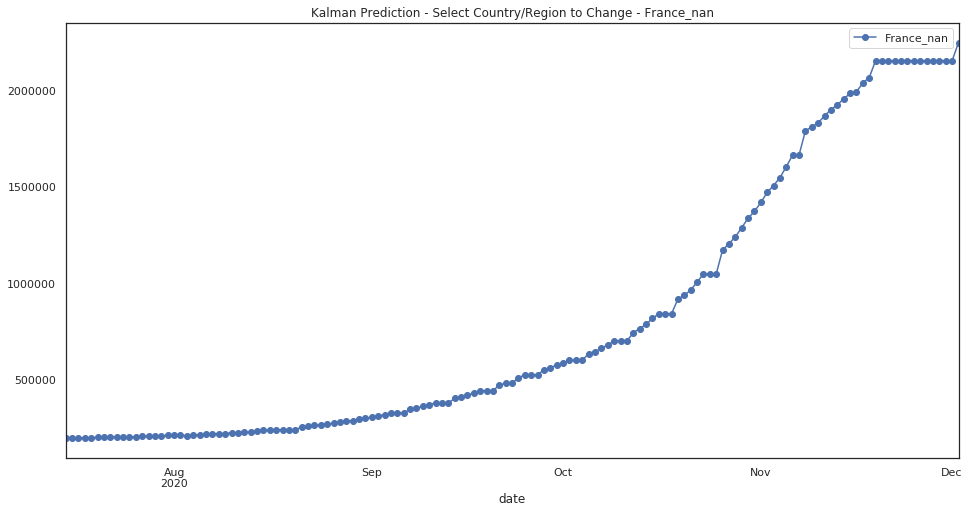

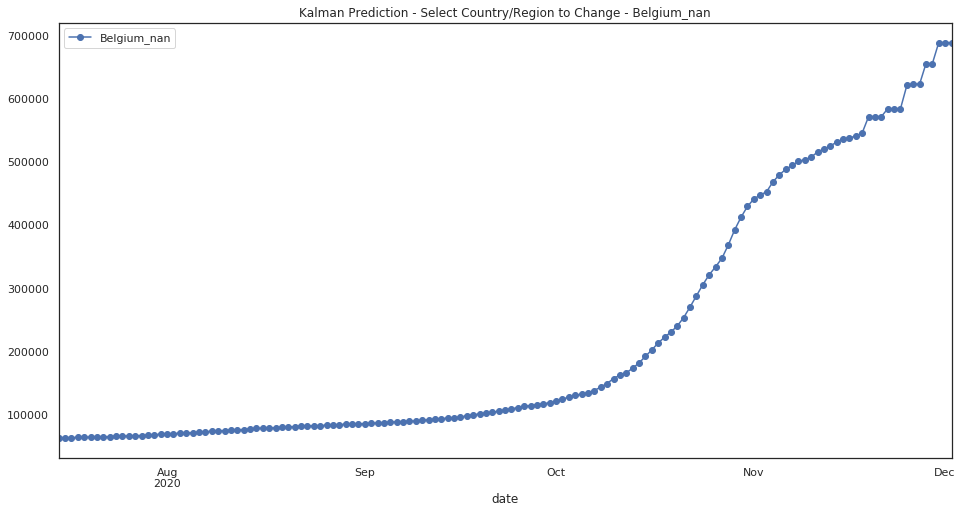

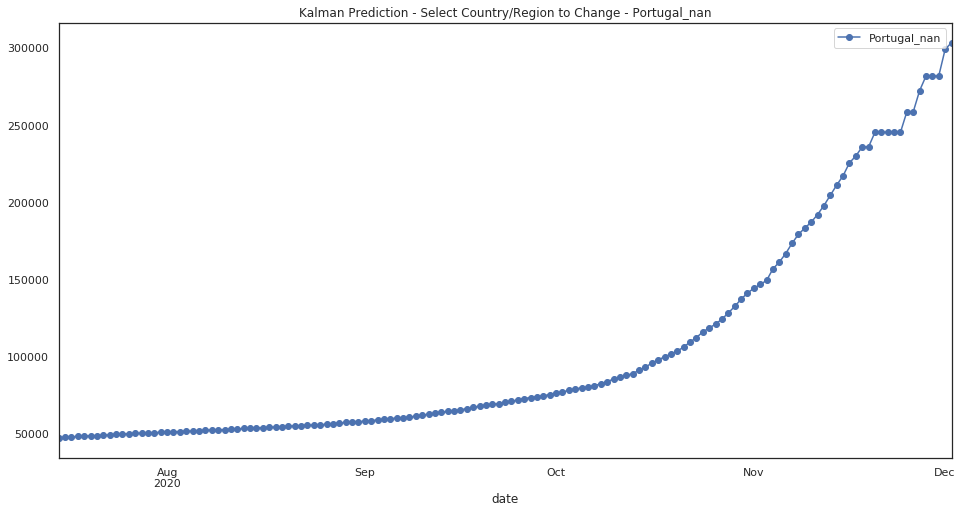

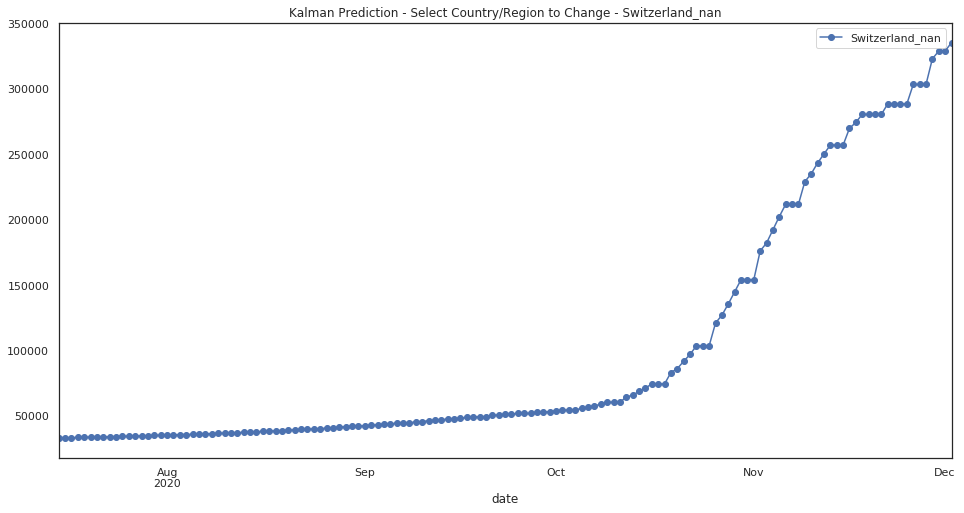

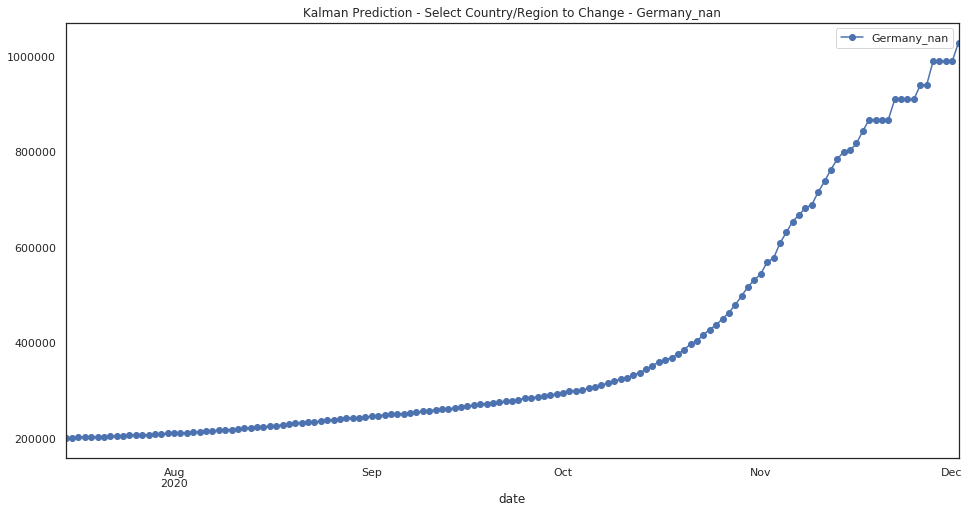

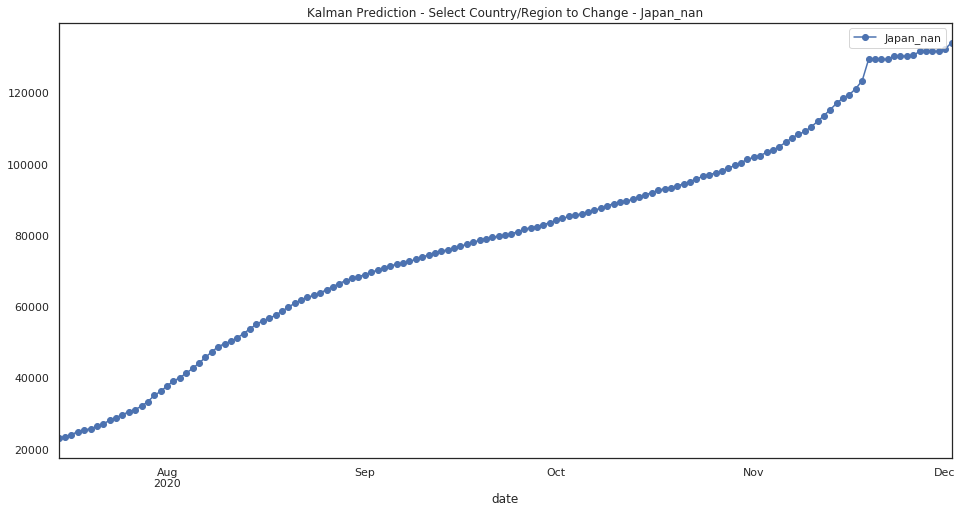

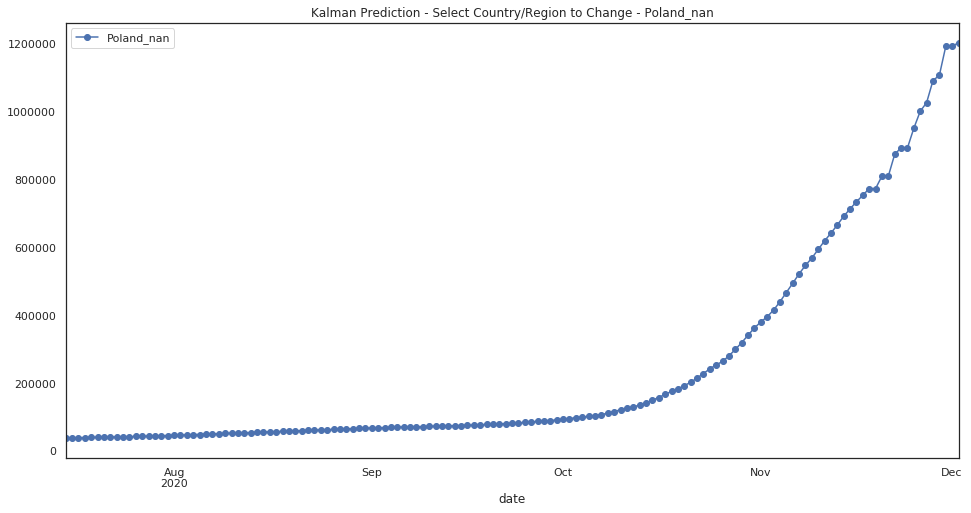

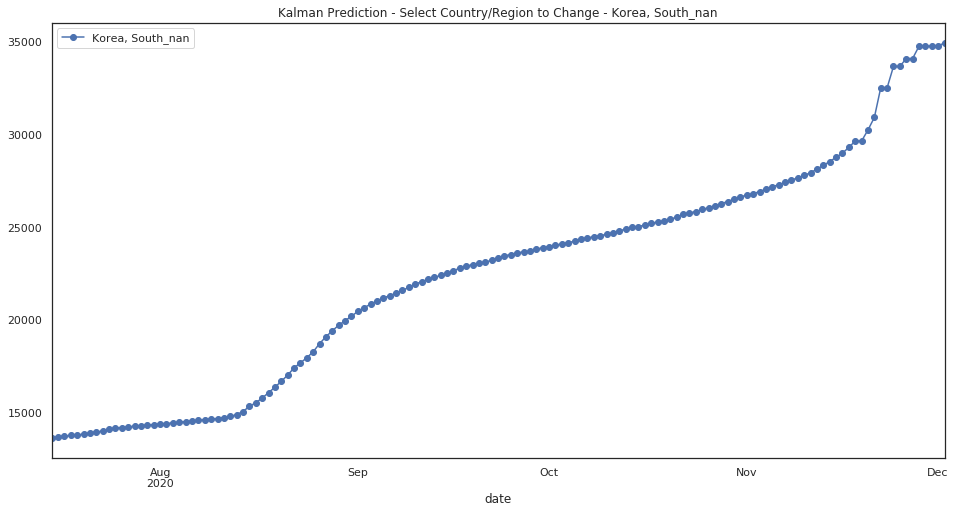

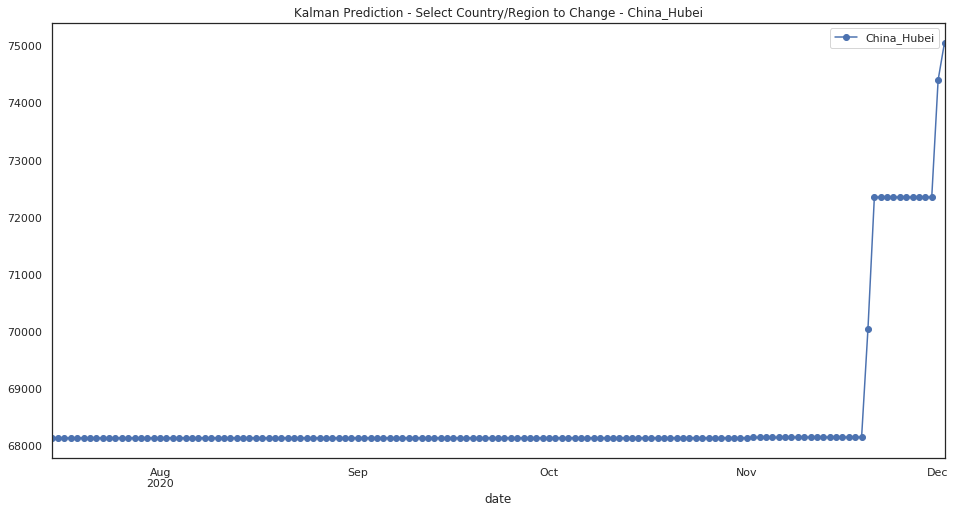

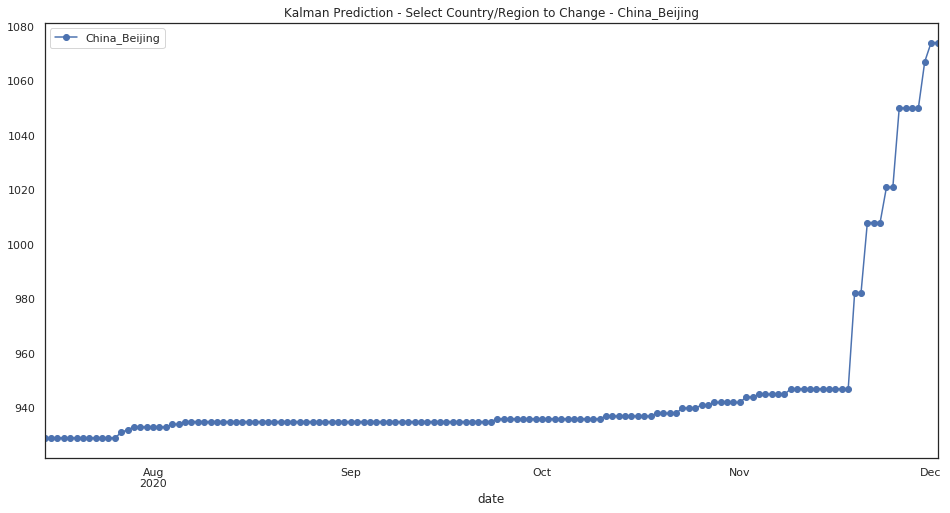

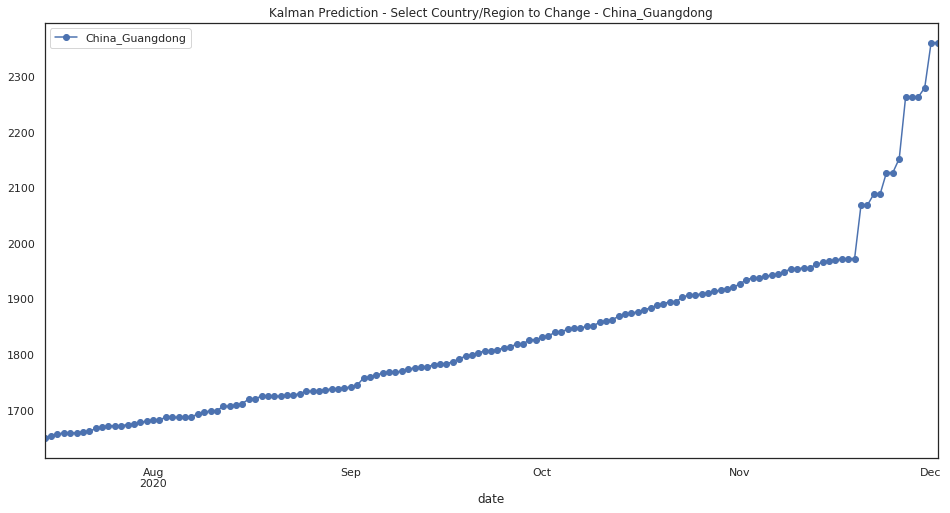

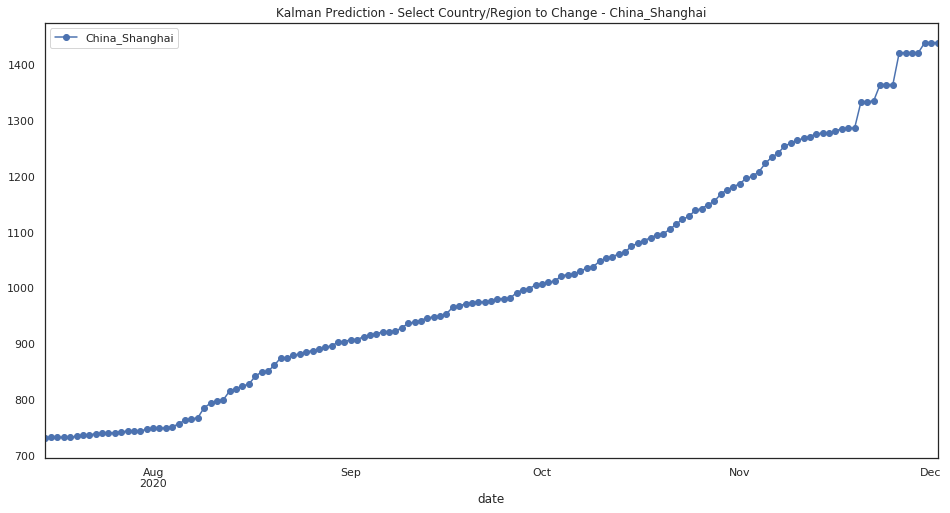

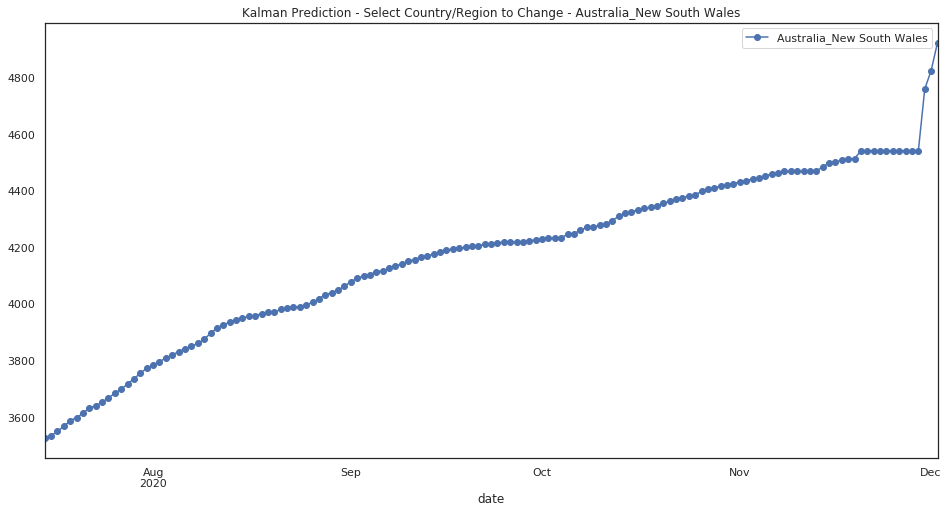

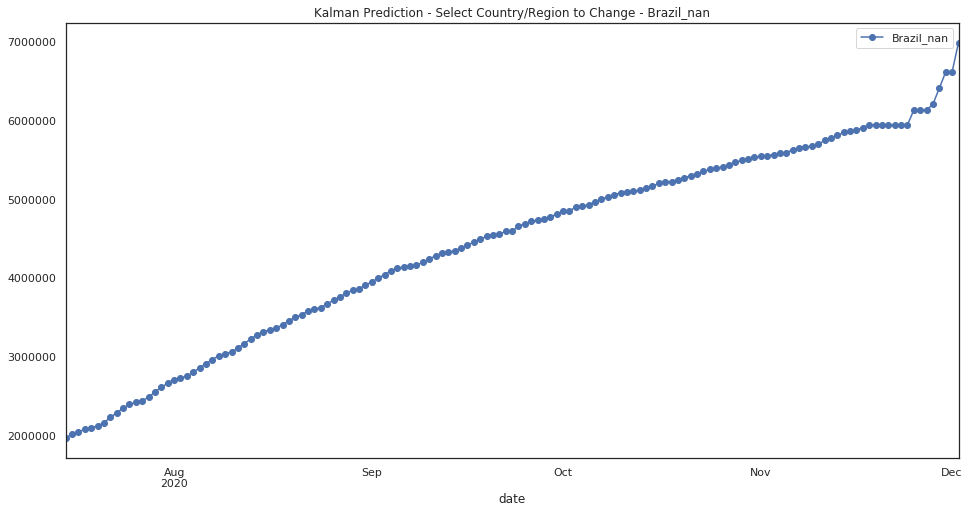

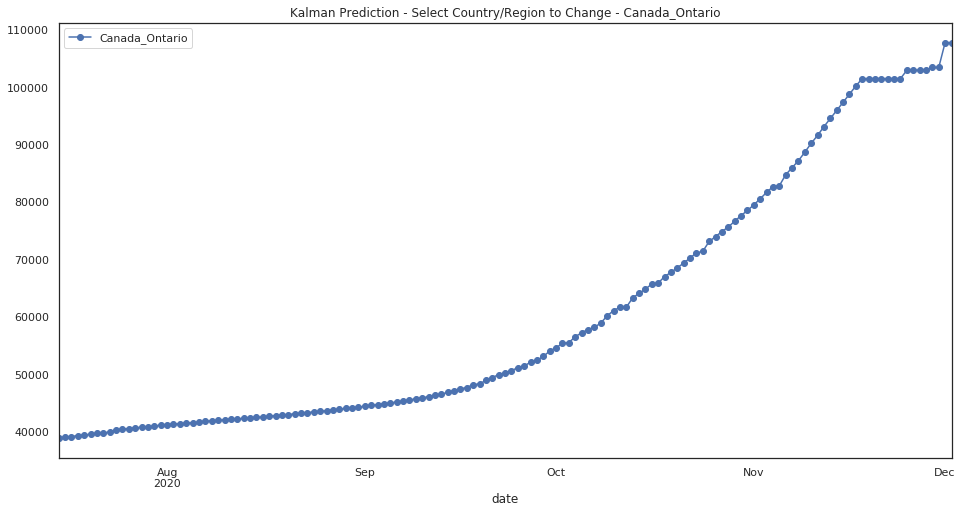

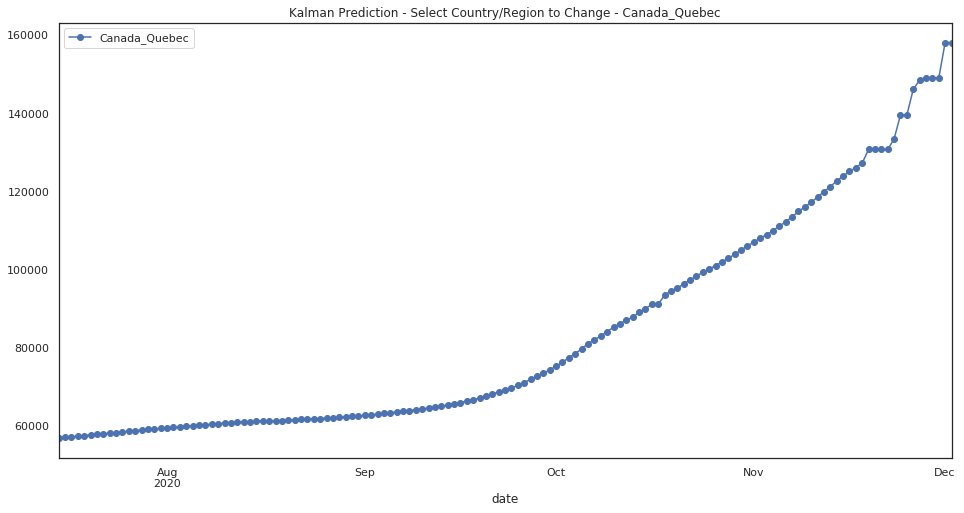

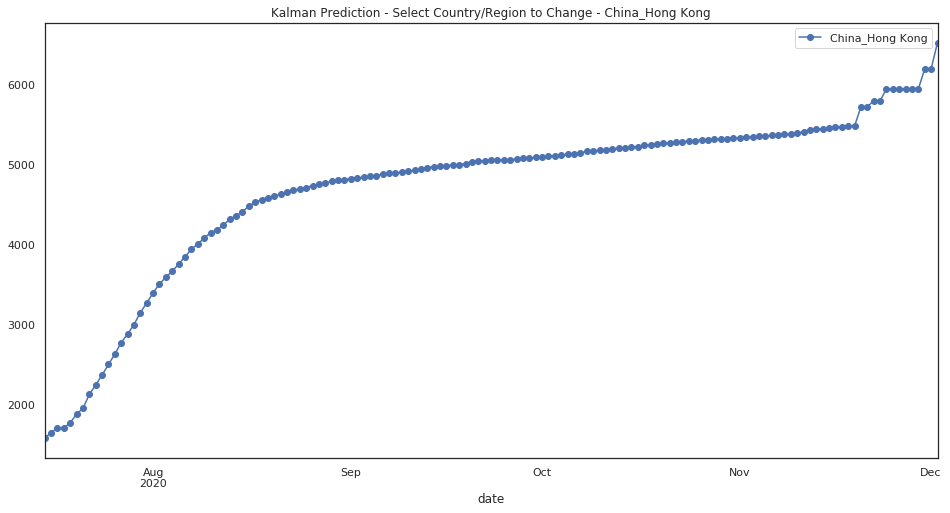

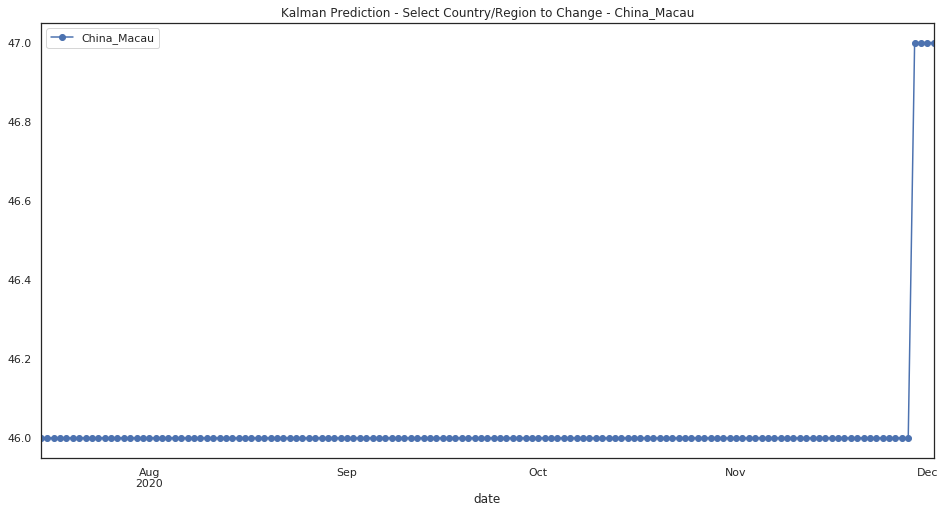

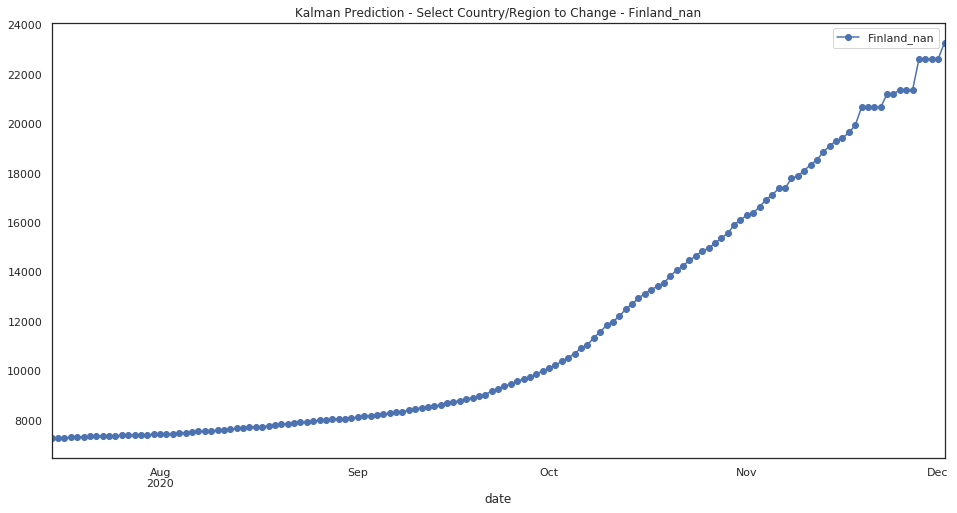

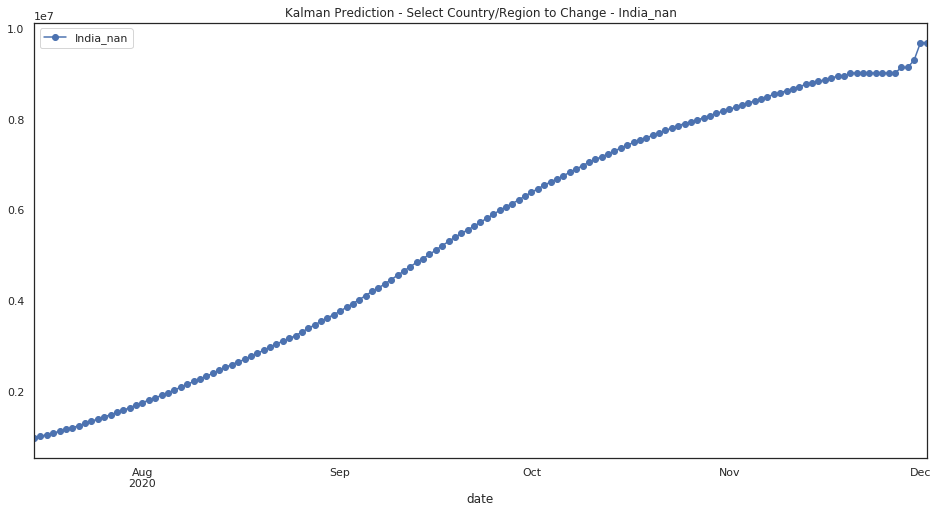

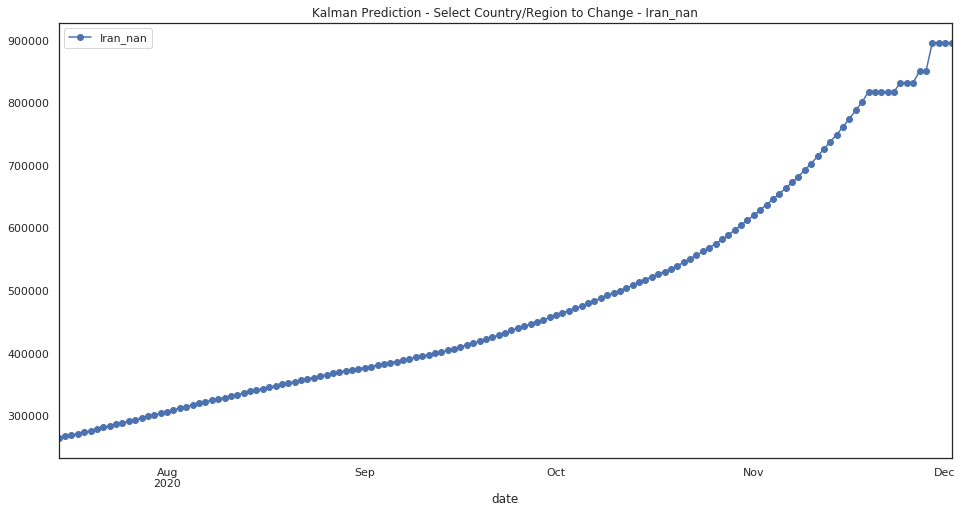

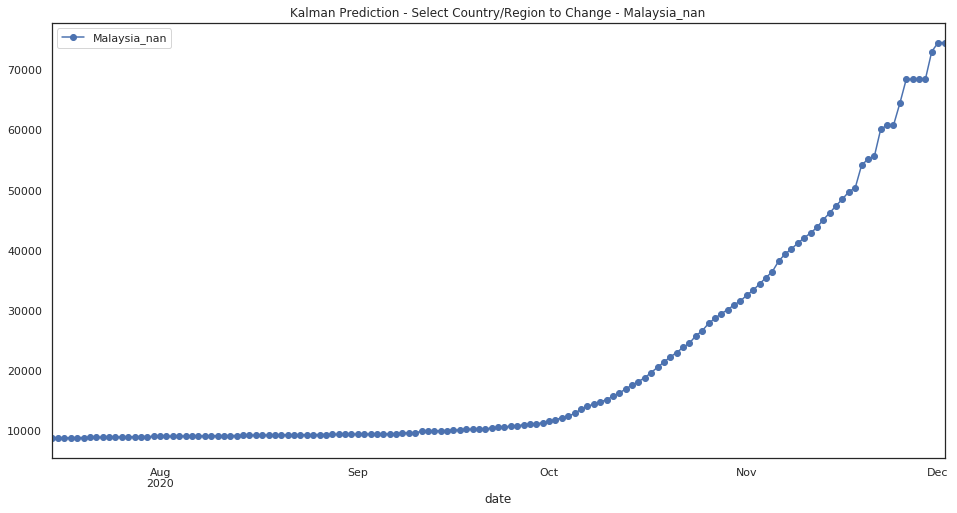

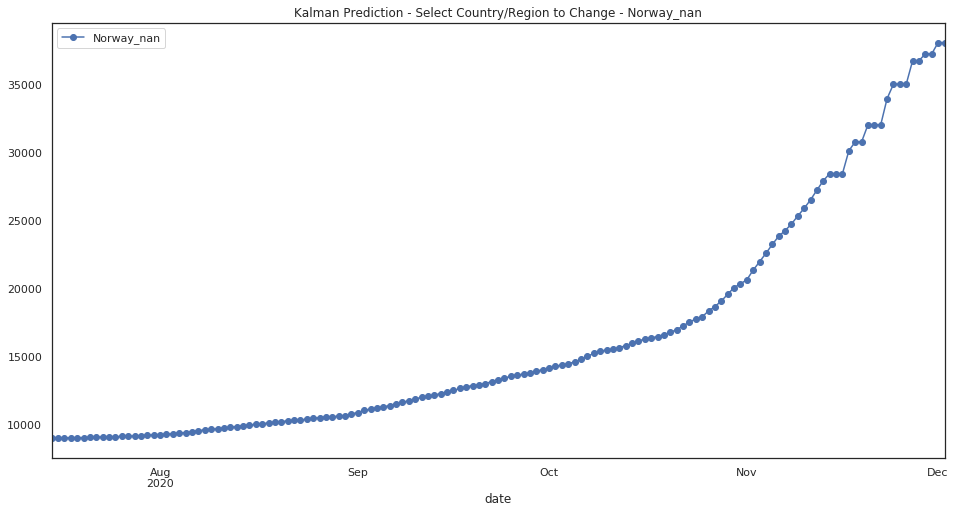

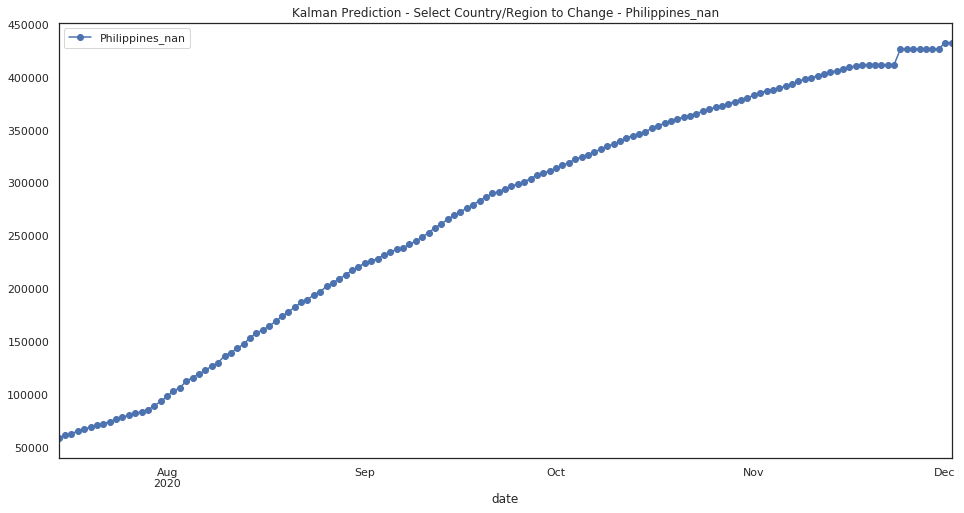

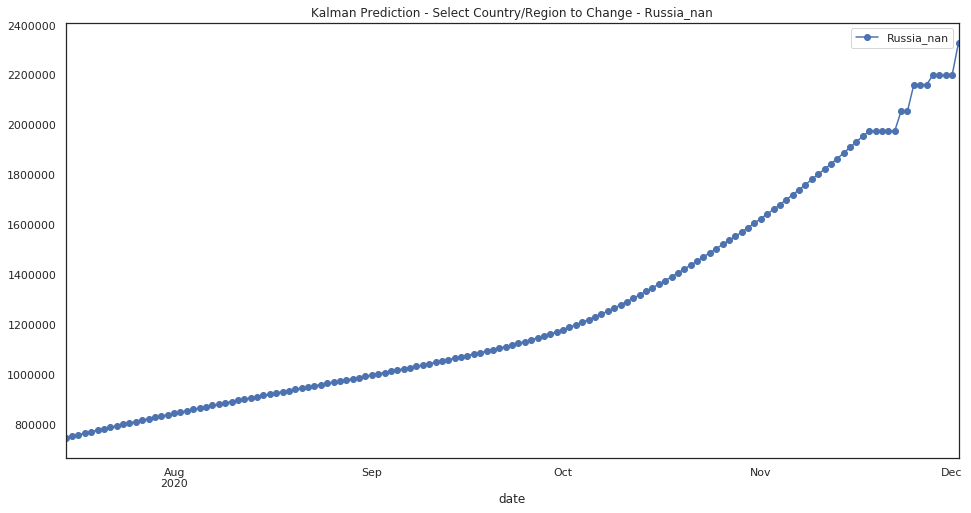

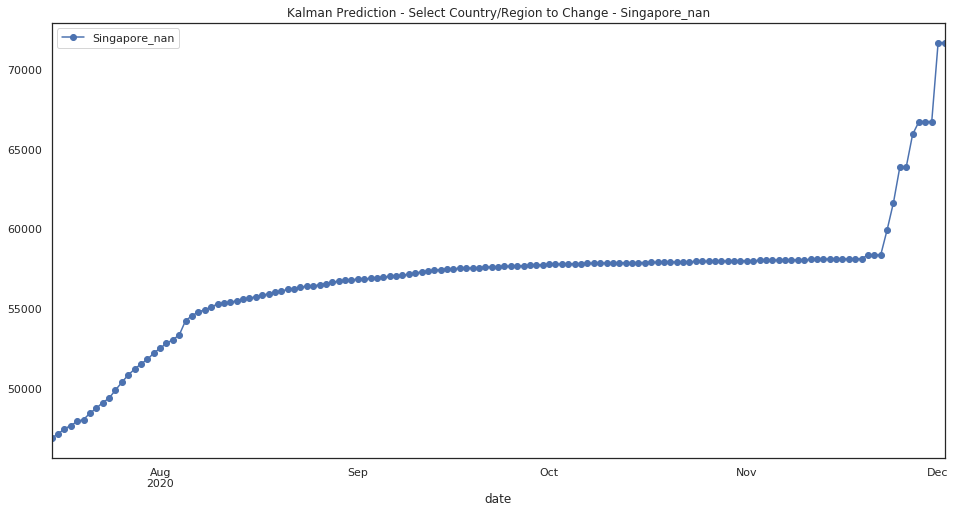

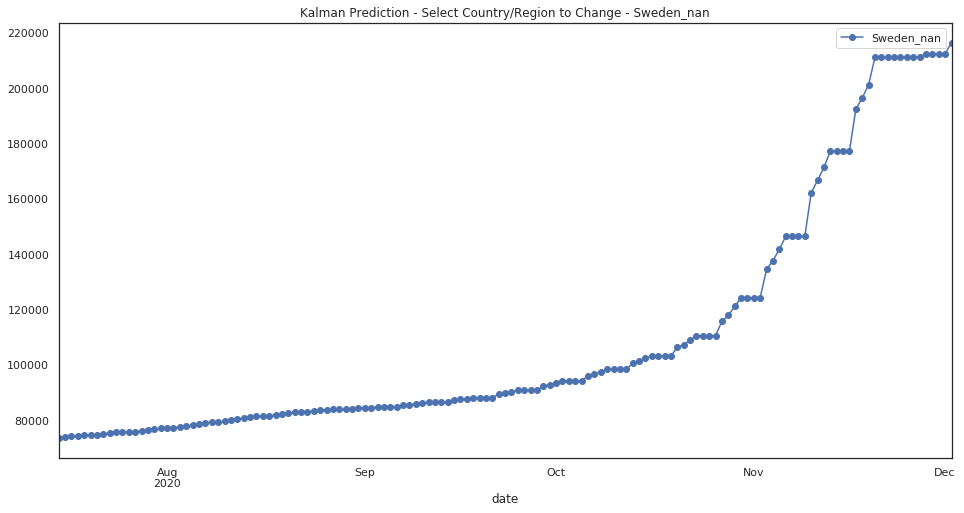

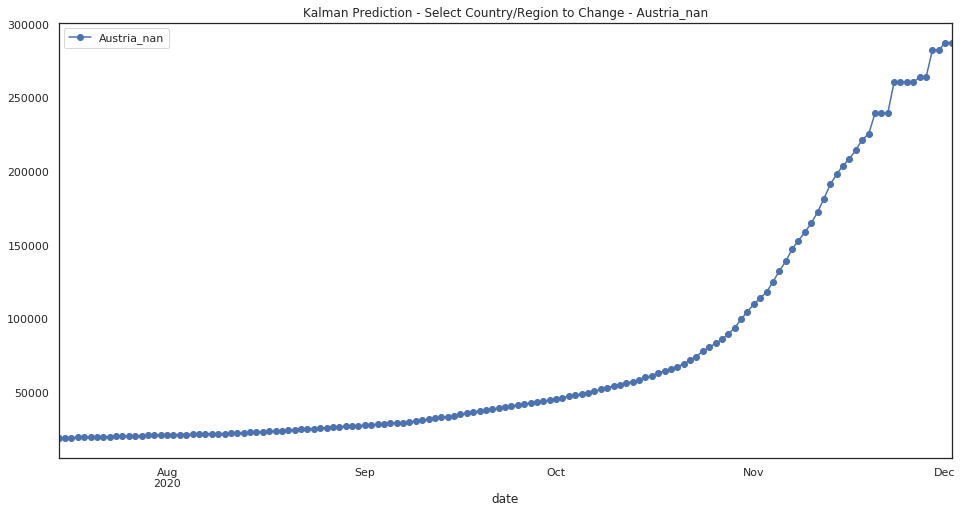

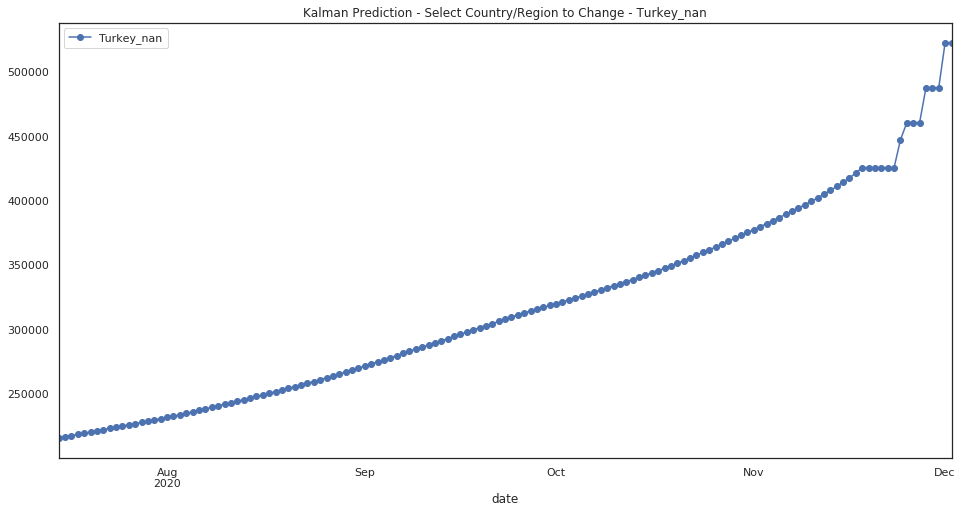

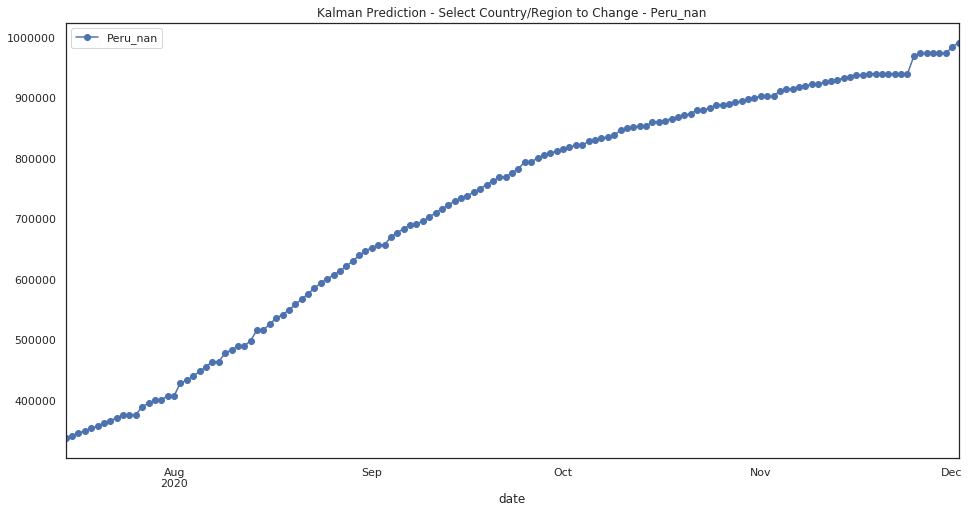

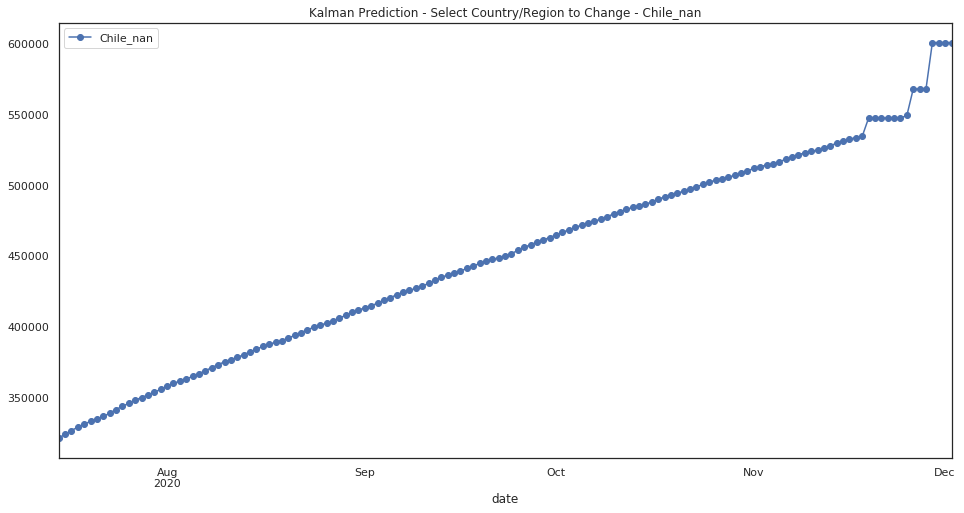

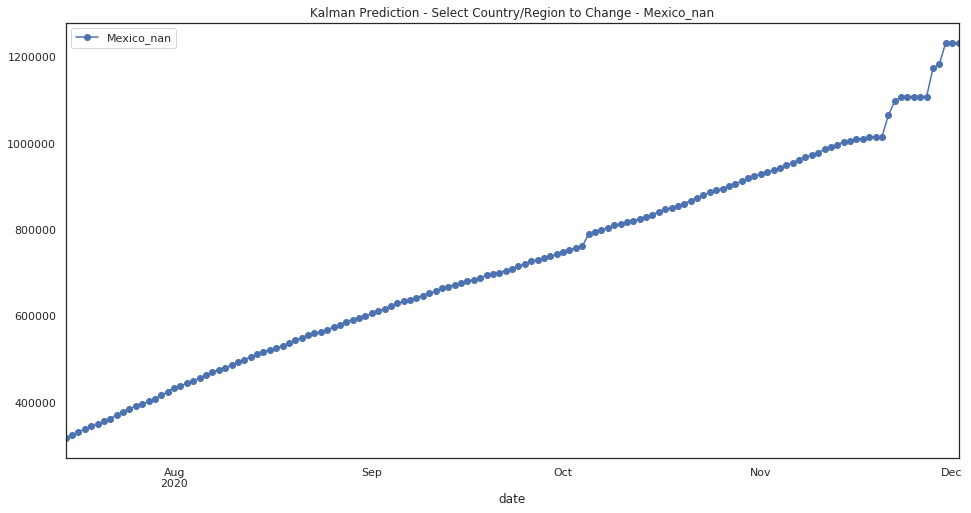

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-12-02 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      15983632.0
India_nan                                   NaN       9698963.0
Brazil_nan                                  NaN       6990901.0
Russia_nan                                  NaN       2330179.0
France_nan                                  NaN       2247053.0
Spain_nan                                   NaN       2048876.0
United Kingdom_nan                          NaN       1744341.0
Argentina_nan                               NaN       1681577.0
Italy_nan                                   NaN       1643552.0
Colombia_nan                                NaN       1374772.0
Mexico_nan                                  NaN       1233564.0
Poland_nan                                  NaN       1202318.0
Germany_nan                                 NaN       1028656.0
Peru_nan                                    NaN        991363.0
South Africa_nan                            NaN        952888.0
Iran_nan                                    NaN        896589.0
Ukraine_nan                                 NaN        748887.0
Belgium_nan                                 NaN        688657.0
Iraq_nan                                    NaN        633624.0
Czechia_nan                                 NaN        623107.0
Chile_nan                                   NaN        600891.0
Indonesia_nan                               NaN        569938.0
Bangladesh_nan                              NaN        559133.0
Turkey_nan                                  NaN        522569.0
Netherlands_nan                             NaN        477657.0
Romania_nan                                 NaN        453695.0
Philippines_nan                             NaN        432893.0
Saudi Arabia_nan                            NaN        415669.0
Morocco_nan                                 NaN        381484.0
Pakistan_nan                                NaN        376284.0
...                                         ...             ...
Saint Vincent and the Grenadines_nan        NaN           102.0
Canada_Prince Edward Island                 NaN            79.0
United Kingdom_British Virgin Islands       NaN            78.0
Dominica_nan                                NaN            77.0
China_Ningxia                               NaN            75.0
Australia_Northern Territory                NaN            57.0
China_Macau                                 NaN            47.0
Fiji_nan                                    NaN            43.0
Grenada_nan                                 NaN            43.0
Timor-Leste_nan                             NaN            34.0
France_New Caledonia                        NaN            33.0
Laos_nan                                    NaN            33.0
Canada_Yukon                                NaN            29.0
Holy See_nan                                NaN            28.0
Saint Kitts and Nevis_nan                   NaN            22.0
Canada_Northwest Territories                NaN            20.0
Denmark_Greenland                           NaN            20.0
Solomon Islands_nan                         NaN            19.0
China_Qinghai                               NaN            19.0
United Kingdom_Falkland Islands (Malvinas)  NaN            17.0
United Kingdom_Montserrat                   NaN            16.0
Canada_Grand Princess                       NaN            16.0
France_Saint Pierre and Miquelon            NaN            16.0
Western Sahara_nan                          NaN            10.0
Marshall Islands_nan                        NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             3.0
Vanuatu_nan                                 NaN             1.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[269 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          43956.0      16764.0      31576.0      14249.0   
2020-07-16          44022.0      16850.0      32085.0      14262.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22549.0        880.0   
2020-07-20          35475.0       4090.0      23115.0        880.0   
2020-07-21          35526.0       4171.0      23691.0        884.0   
2020-07-22          35615.0       4290.0      24293.0        884.0   
2020-07-23          36007.0       4485.0      25452.0        899.0   
2020-07-24          36069.0       4474.0      26118.0        975.0   
2020-07-25          36141.0       4570.0      26721.0        897.0   
2020-07-26          36253.0       4793.0      27341.0        980.0   
2020-07-27          36352.0       4763.0      27962.0        989.0   
2020-07-28          36460.0       4906.0      28598.0        907.0   
2020-07-29          36563.0       5026.0      29214.0       1003.0   
2020-07-30          36639.0       5151.0      29828.0        918.0   
2020-07-31          36765.0       5272.0      30402.0        956.0   
2020-08-01          36807.0       5414.0      30967.0        972.0   
2020-08-02          36823.0       5443.0      31489.0       1010.0   
2020-08-03          36857.0       5547.0      32005.0       1018.0   
2020-08-04          36887.0       5730.0      32535.0        937.0   
2020-08-05          36932.0       5806.0      33078.0        999.0   
2020-08-06          36994.0       5923.0      33644.0       1028.0   
2020-08-07          37104.0       6095.0      34176.0        958.0   
2020-08-08          37147.0       6213.0      34721.0        955.0   
2020-08-09          37161.0       6373.0      35197.0       1044.0   
2020-08-10          37259.0       6480.0      35748.0       1048.0   
2020-08-11          37355.0       6645.0      36238.0        963.0   
2020-08-12          37436.0       6761.0      36742.0       1055.0   
2020-08-13          37519.0       6916.0      37230.0        977.0   
...                     ...          ...          ...          ...   
2020-11-04          41906.0      22243.0      59569.0       4910.0   
2020-11-05          42023.0      22660.0      60204.0       5045.0   
2020-11-06          42071.0      23137.0      60841.0       5135.0   
2020-11-07          42132.0      23615.0      61430.0       5135.0   
2020-11-08          42189.0      24123.0      62090.0       5319.0   
2020-11-09          42375.0      24651.0      62743.0       5383.0   
2020-11-10          42536.0      25210.0      63485.0       5437.0   
2020-11-11          42688.0      25720.0      64296.0       5477.0   
2020-11-12          42871.0      26165.0      65147.0       5567.0   
2020-11-13          43045.0      26673.0      66015.0       5616.0   
2020-11-14          43127.0      27177.0      66865.0       5725.0   
2020-11-15          43321.0      27757.0      67725.0       5725.0   
2020-11-16          43483.0      28347.0      68632.0       5872.0   
2020-11-17          43702.0      29032.0      69628.0       5914.0   
2020-11-18          43922.0      29725.0      70669.0       5951.0   
2020-11-19          45017.0      29837.0      70808.0       6018.0   
2020-11-20          45316.0      29965.0      73208.0       6199.0   
2020-11-21          45398.0      29952.0      73780.0       6516.0   
2020-11-22          46508.0      31357.0      77393.0       6567.0   
2020-11-23          46631.0      31668.0      78301.0       6567.0   
2020-11-24          46683.0      32195.0      78577.0       6868.0   
2020-11-25          46679.0      32261.0      78722.0       6868.0   
2020-11-26          46682.0      32287.0      78689.0       7225.0   
2020-11-27          48753.0      32286.0      78689.0       7225.0   
2020-11-28

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'France_nan',
 'Spain_nan',
 'United Kingdom_nan',
 'Argentina_nan',
 'Italy_nan',
 'Colombia_nan',
 'Mexico_nan',
 'Poland_nan',
 'Germany_nan',
 'Peru_nan',
 'South Africa_nan',
 'Iran_nan',
 'Ukraine_nan',
 'Belgium_nan',
 'Iraq_nan',
 'Czechia_nan',
 'Chile_nan',
 'Indonesia_nan',
 'Bangladesh_nan',
 'Turkey_nan',
 'Netherlands_nan',
 'Romania_nan',
 'Philippines_nan',
 'Saudi Arabia_nan',
 'Morocco_nan',
 'Pakistan_nan',
 'Israel_nan',
 'Switzerland_nan',
 'Portugal_nan',
 'Austria_nan',
 'Nepal_nan',
 'Hungary_nan',
 'Sweden_nan',
 'United Arab Emirates_nan',
 'Ecuador_nan',
 'Jordan_nan',
 'Bolivia_nan',
 'Kazakhstan_nan',
 'Costa Rica_nan',
 'Panama_nan',
 'Canada_Quebec',
 'Kuwait_nan',
 'Qatar_nan',
 'Oman_nan',
 'Honduras_nan',
 'Dominican Republic_nan',
 'Serbia_nan',
 'Armenia_nan',
 'Ethiopia_nan',
 'Lebanon_nan',
 'Japan_nan',
 'Belarus_nan',
 'Bulgaria_nan',
 'Venezuela_nan',
 'Guatemala_nan',
 'Egypt_na

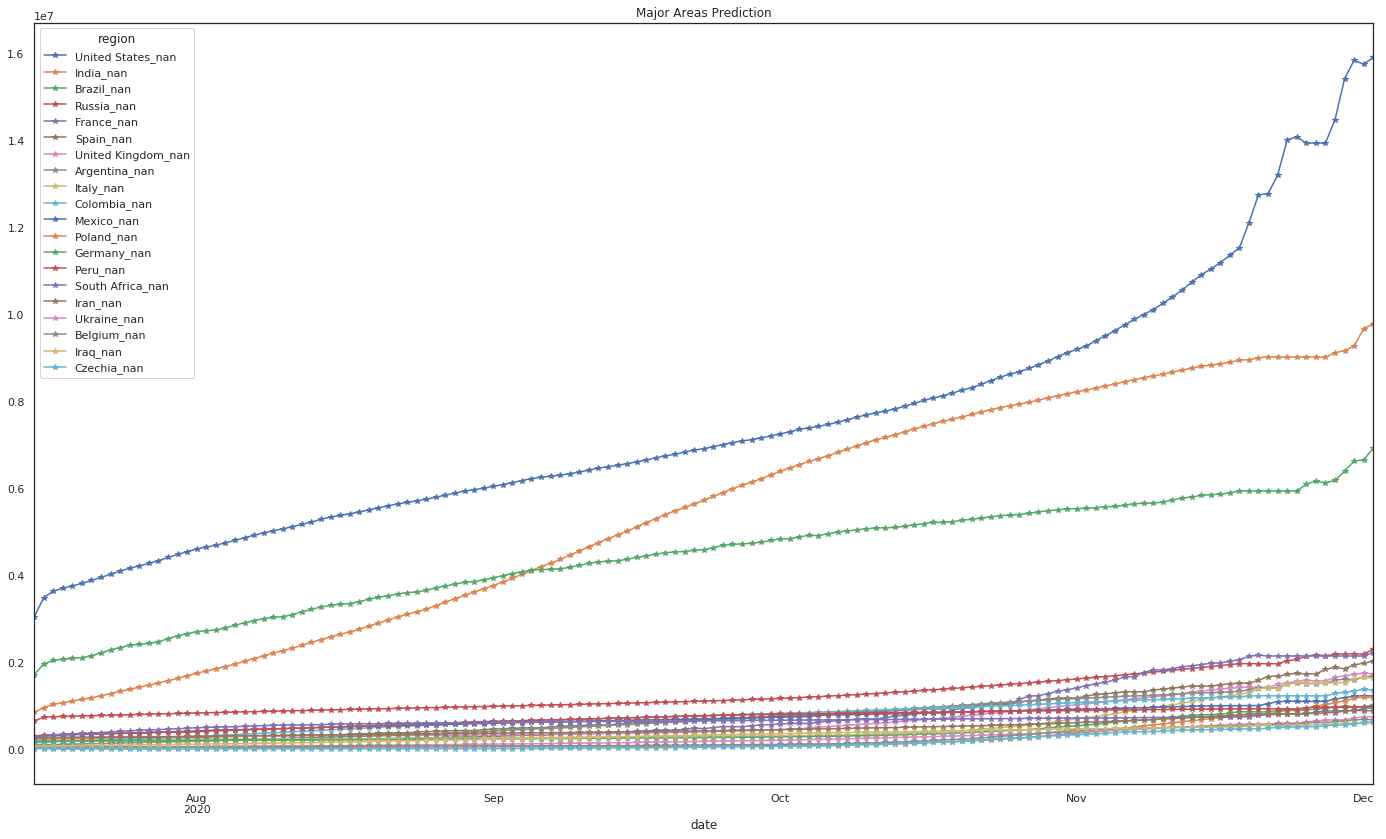

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

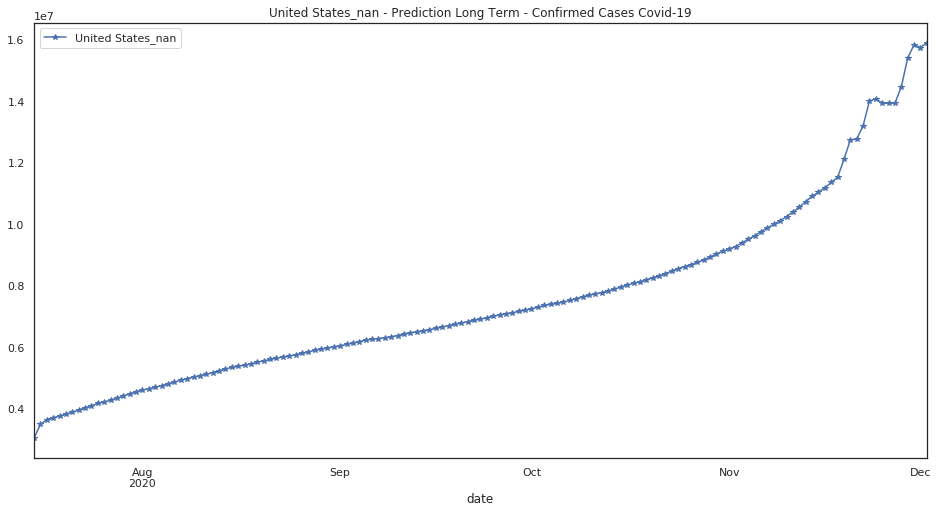

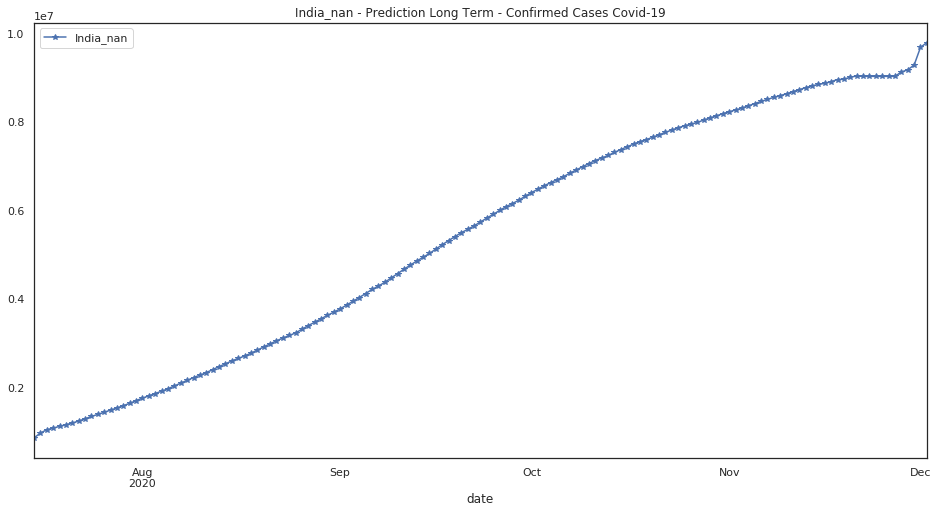

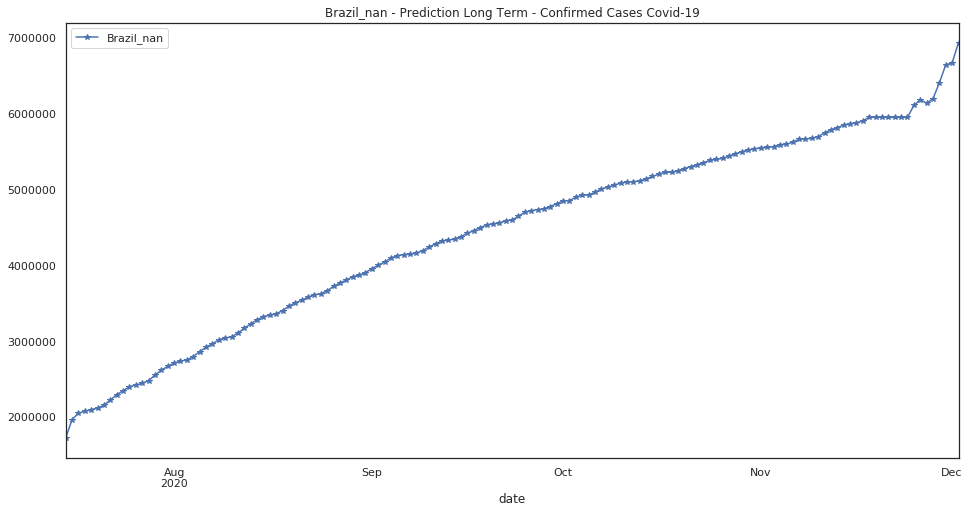

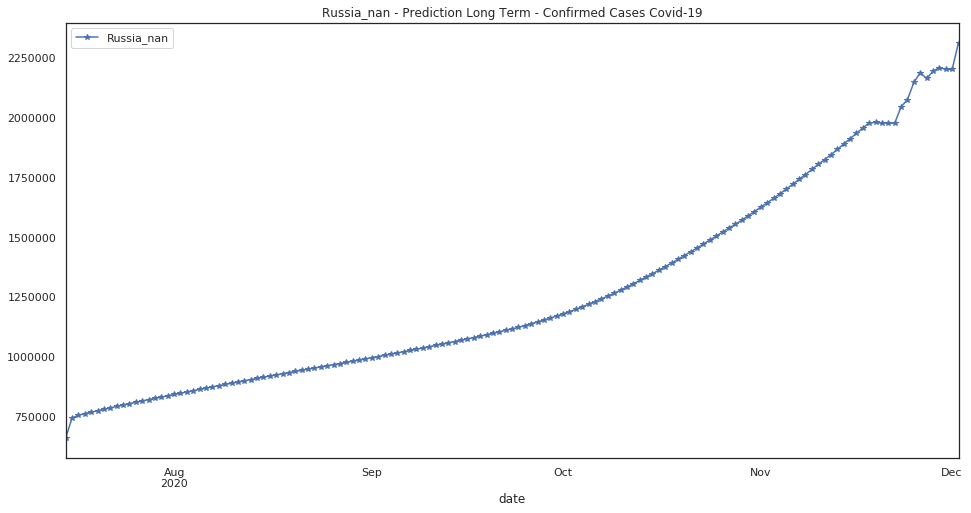

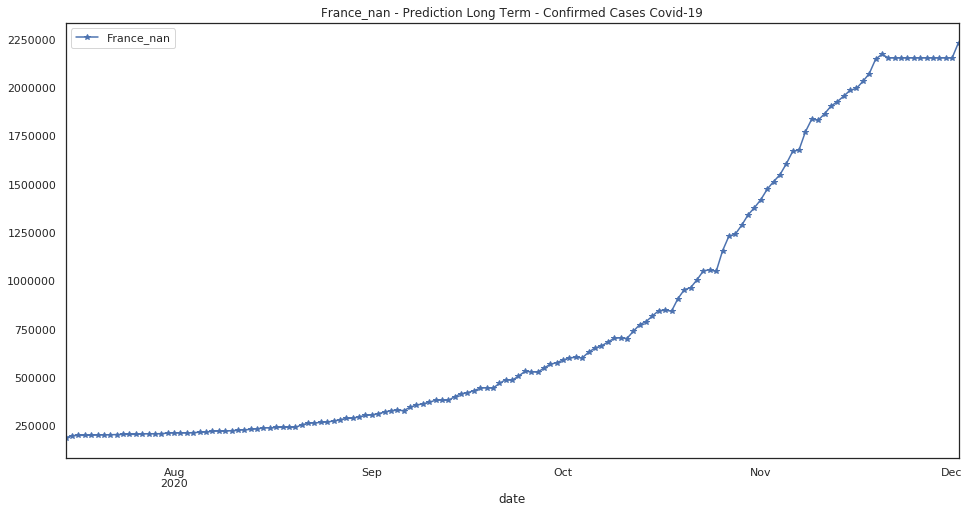

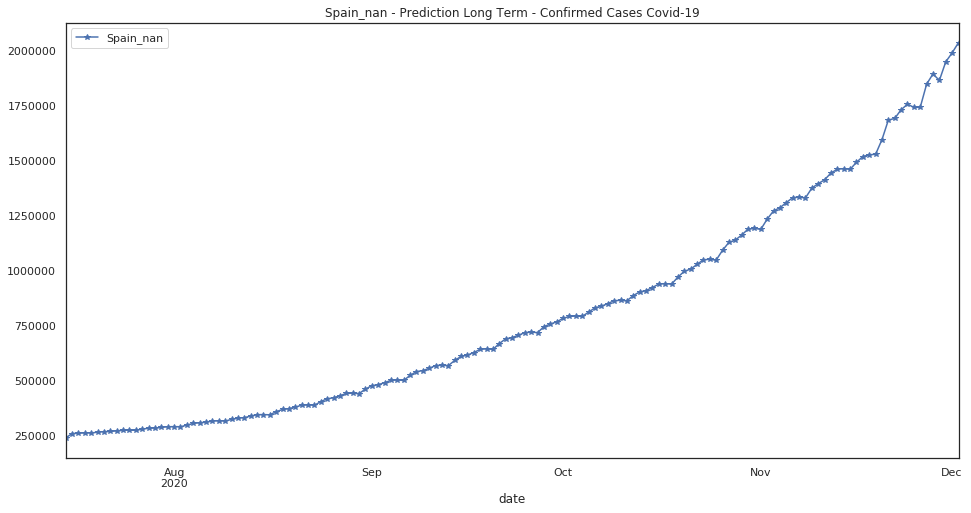

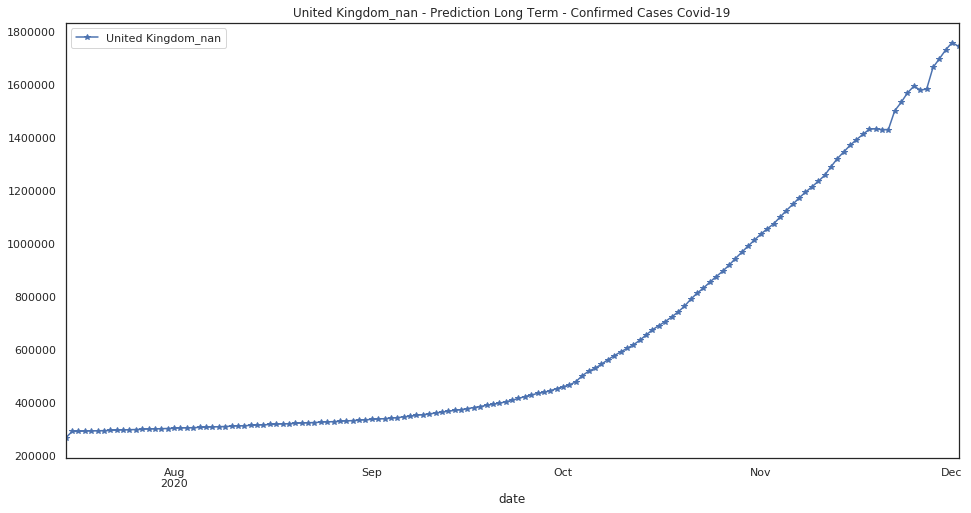

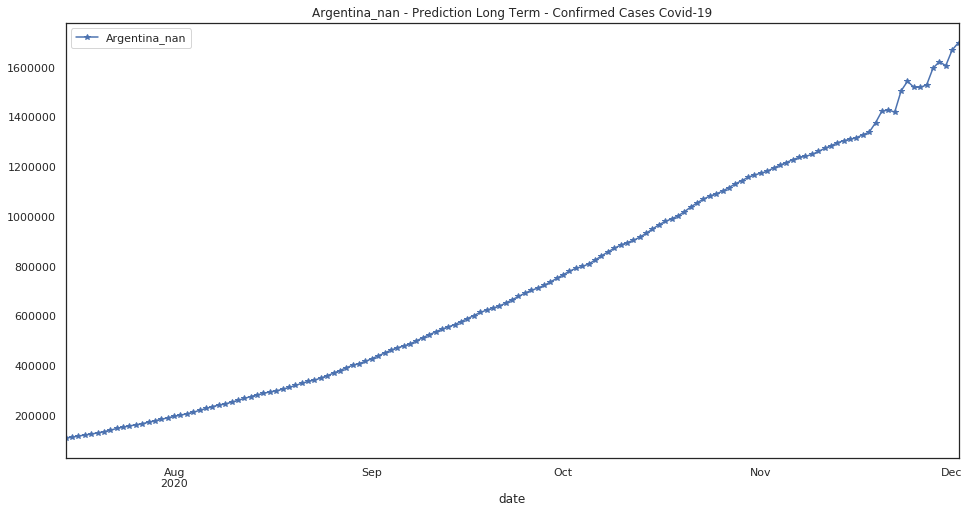

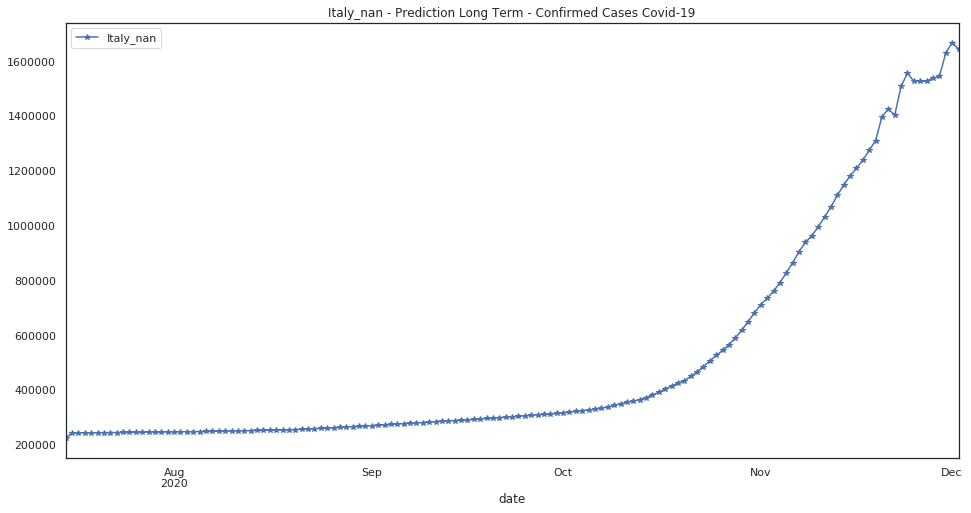

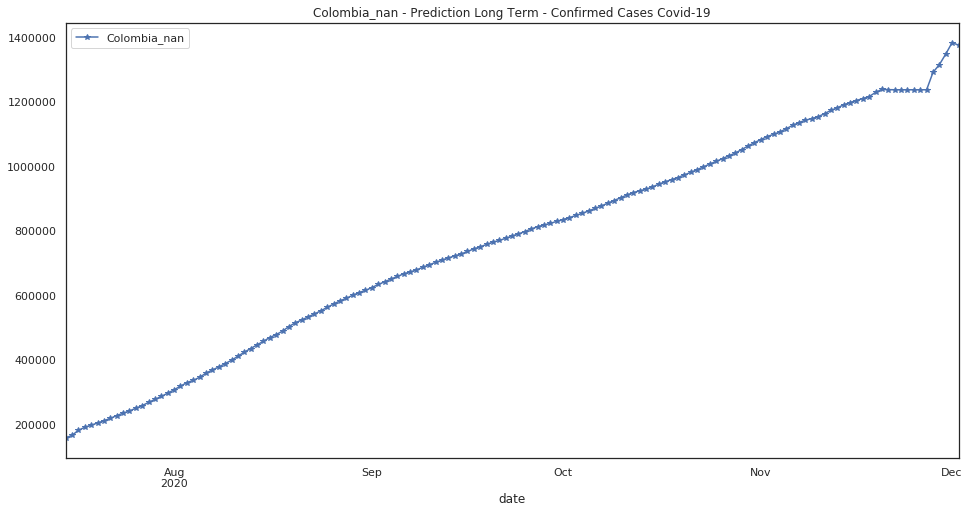

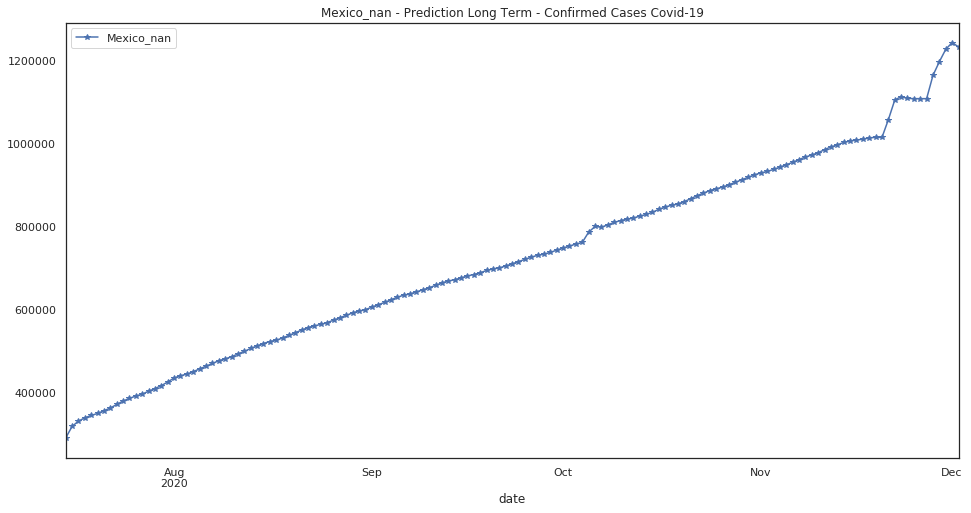

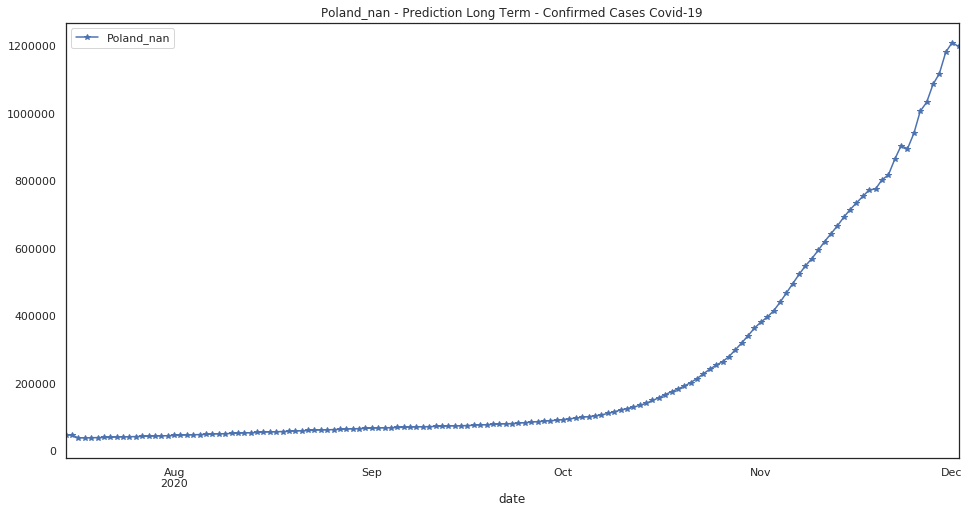

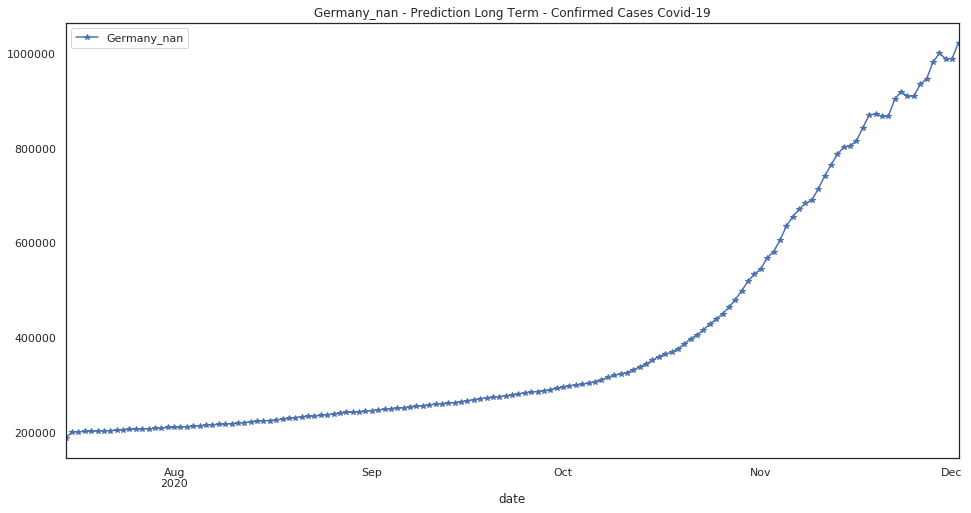

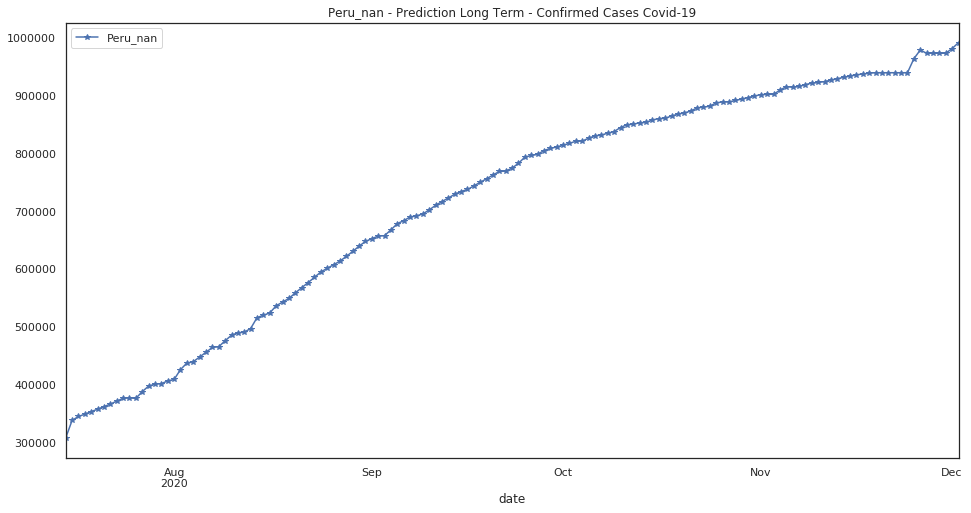

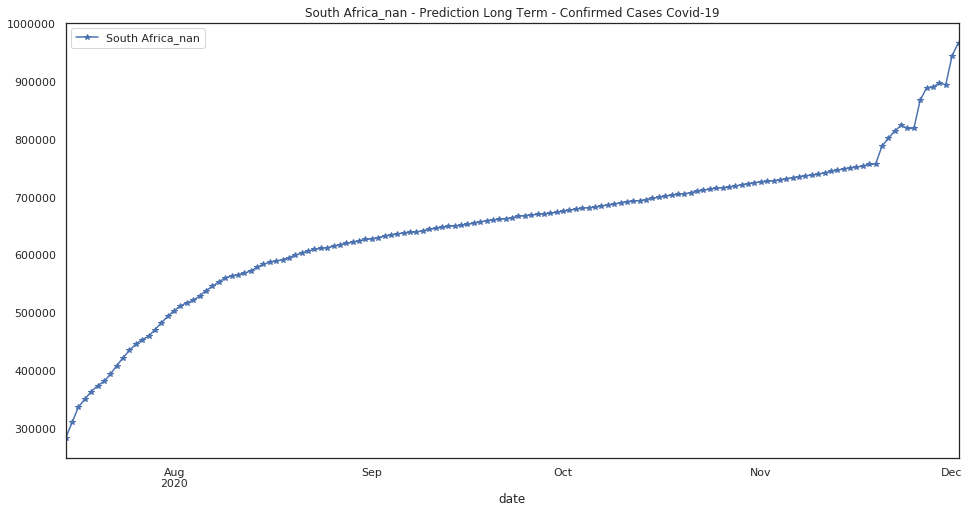

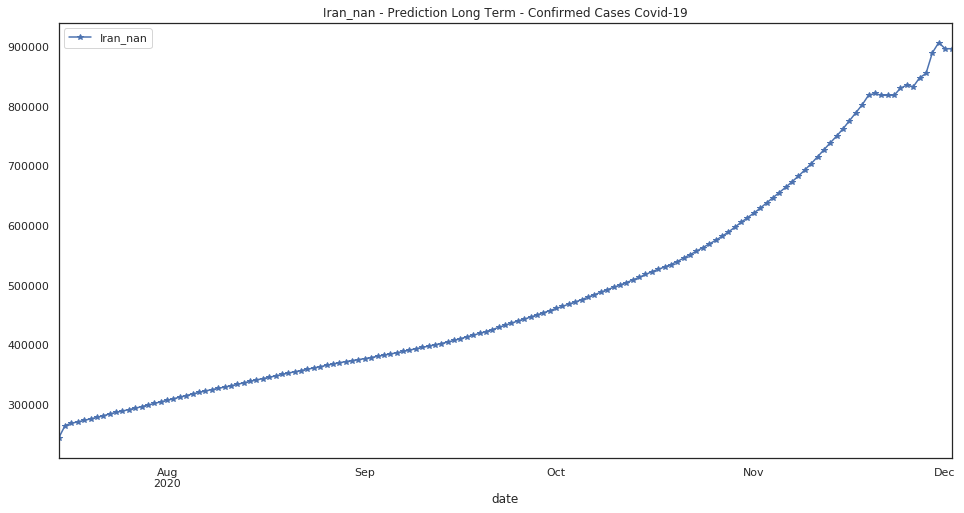

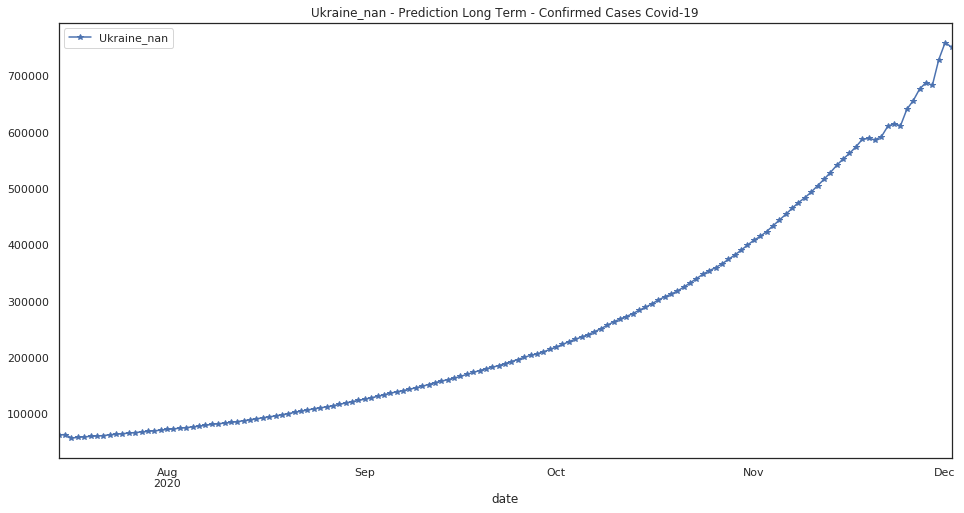

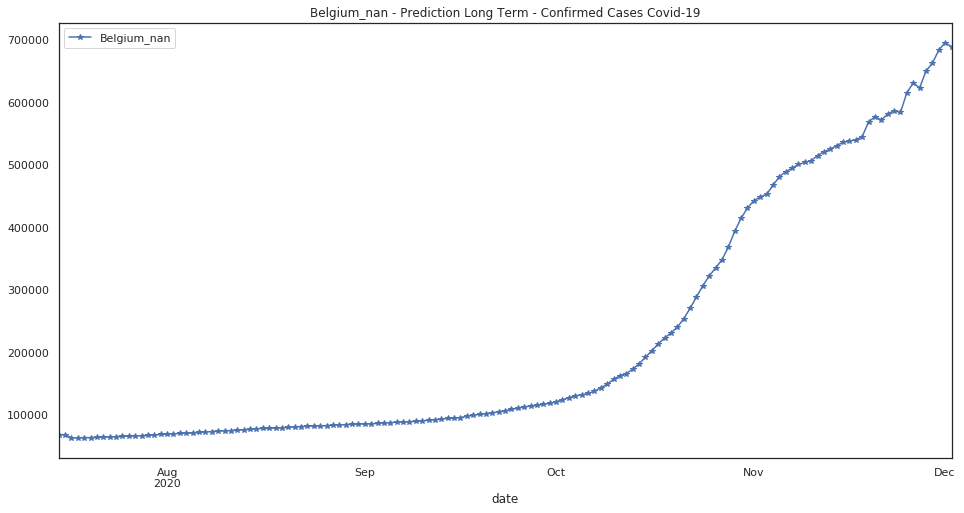

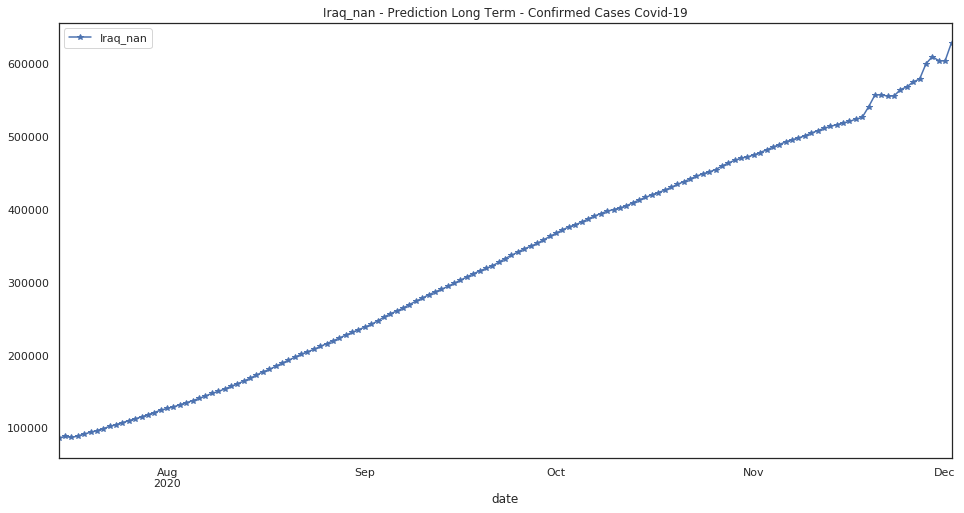

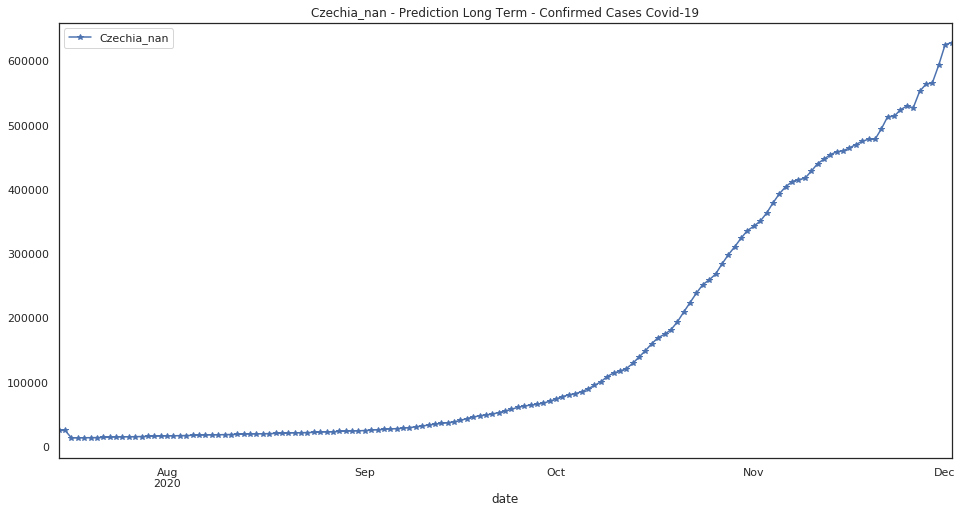

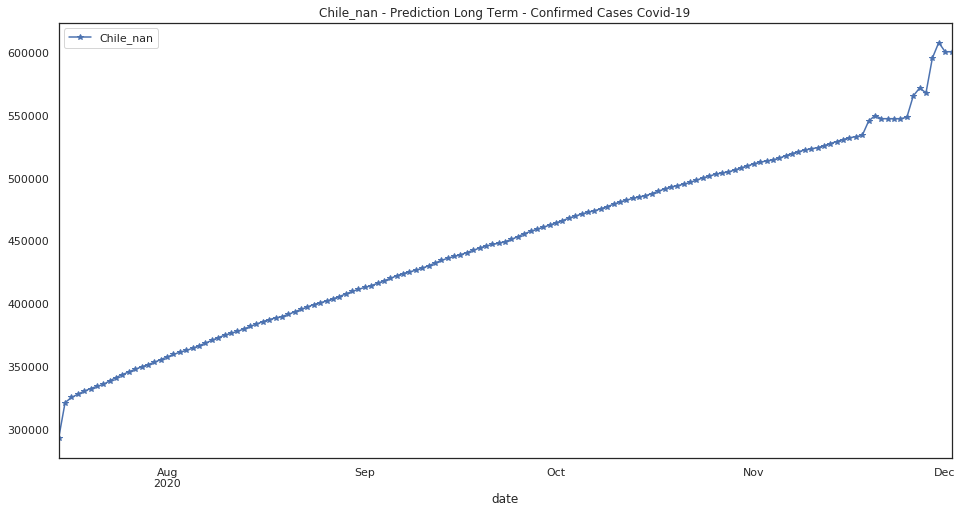

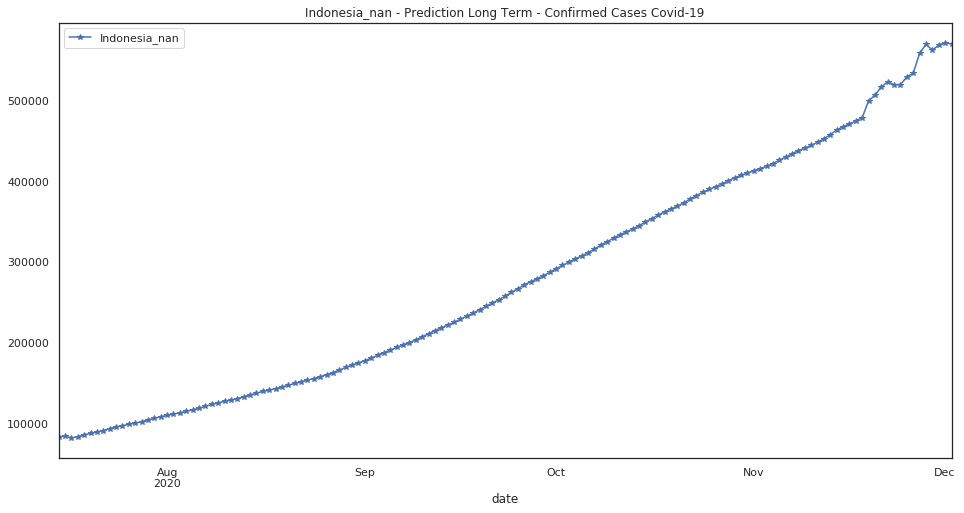

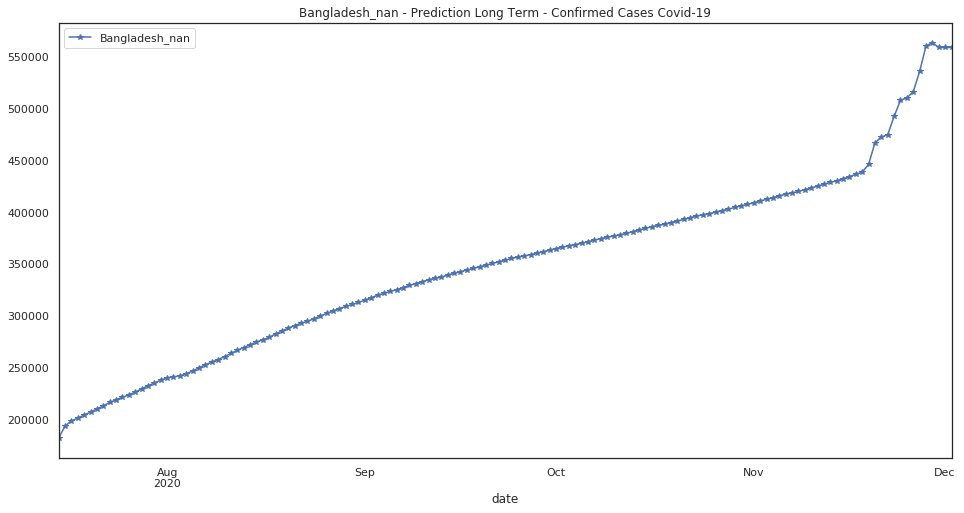

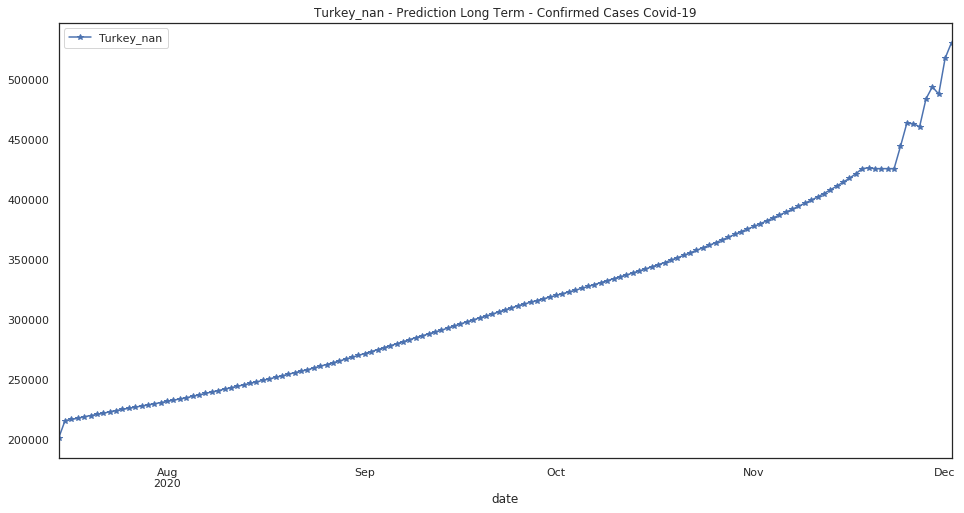

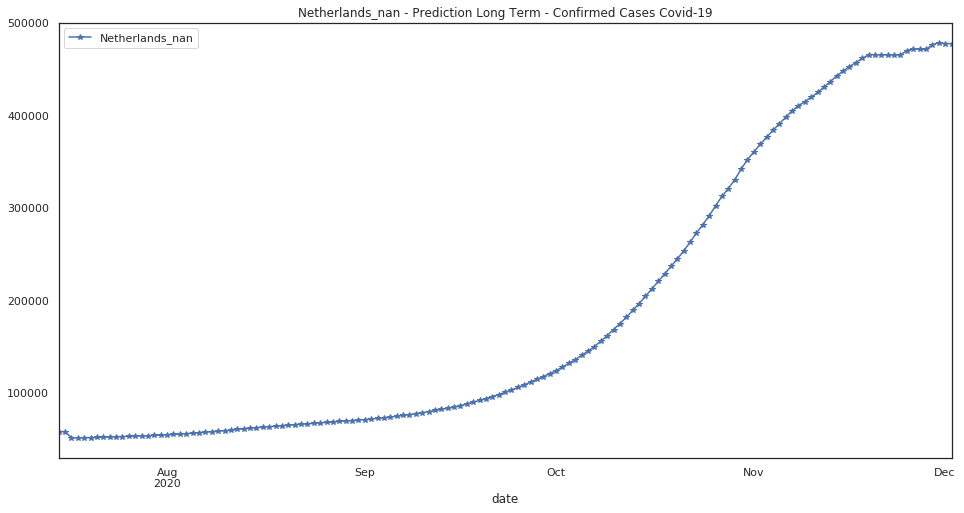

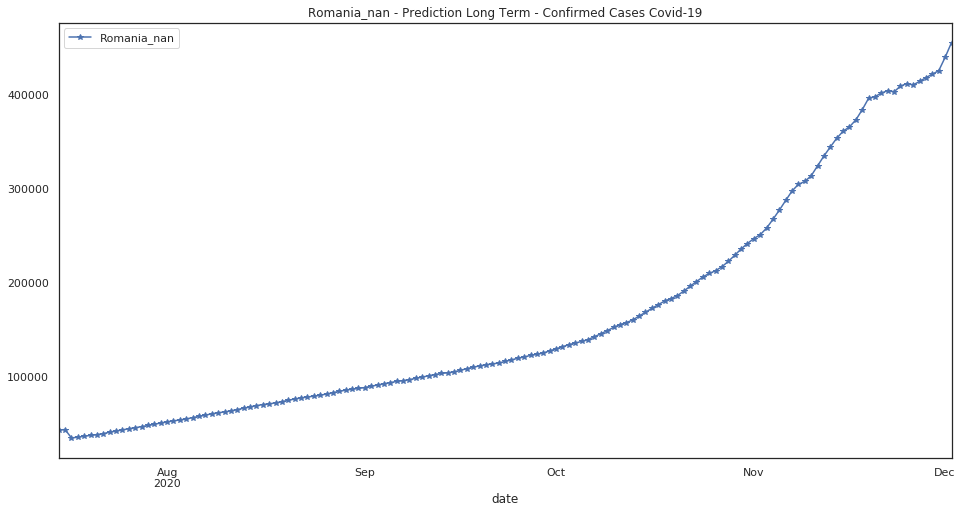

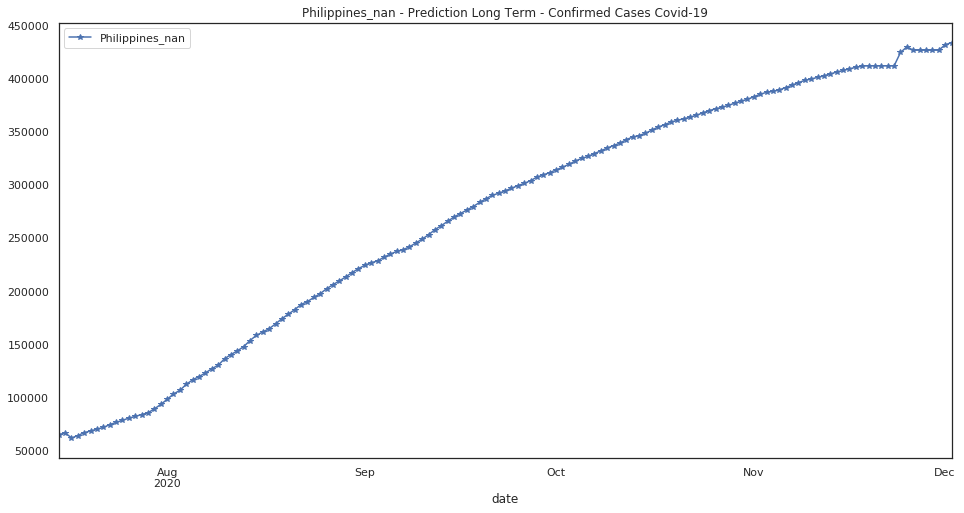

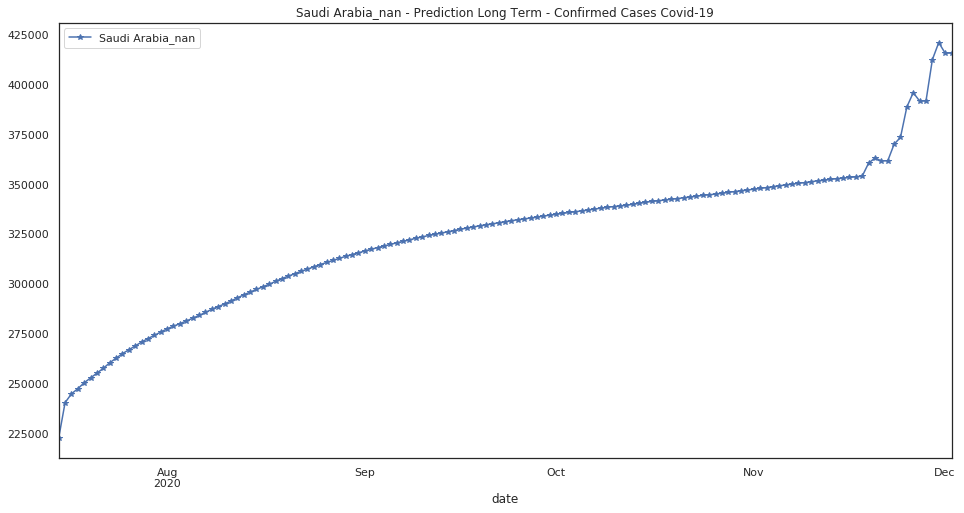

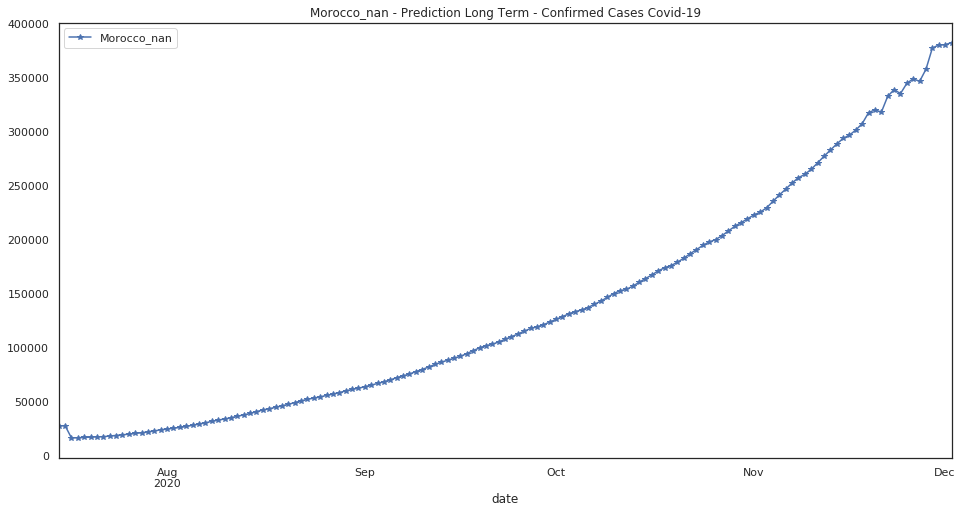

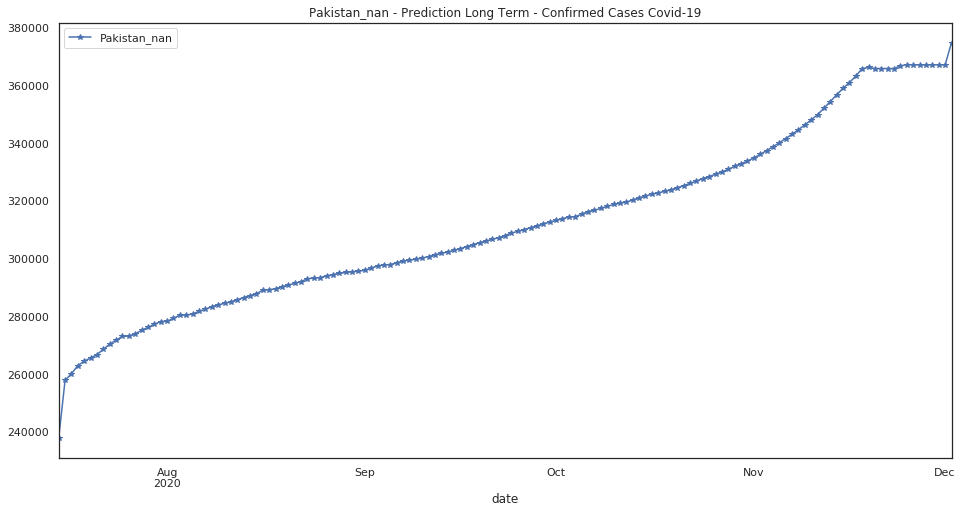

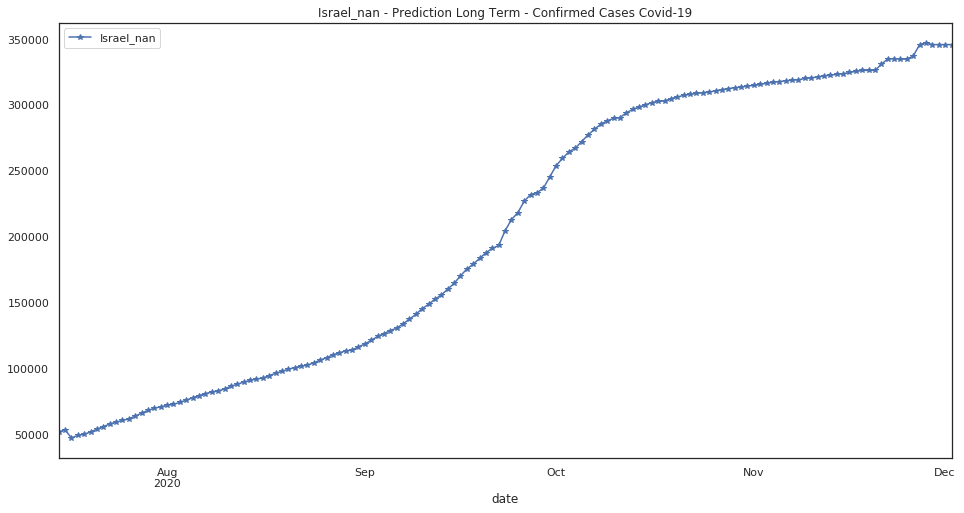

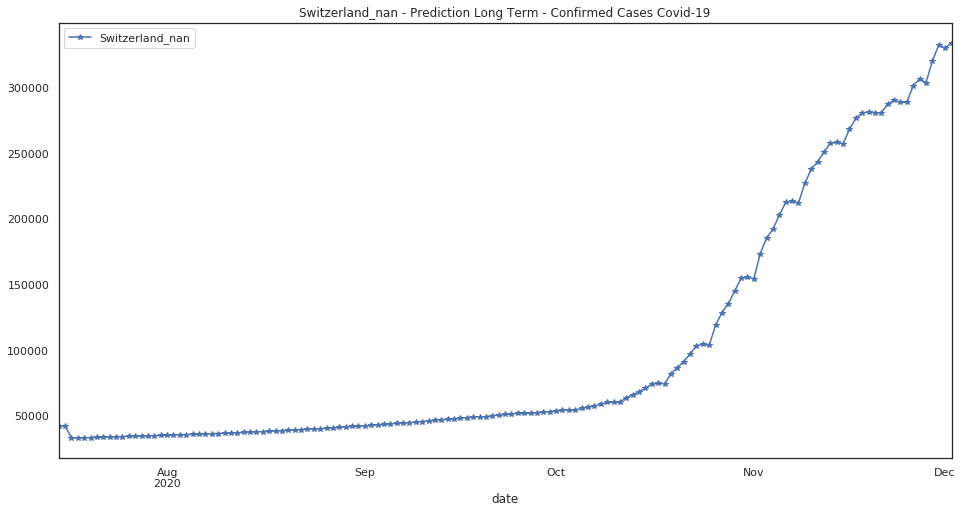

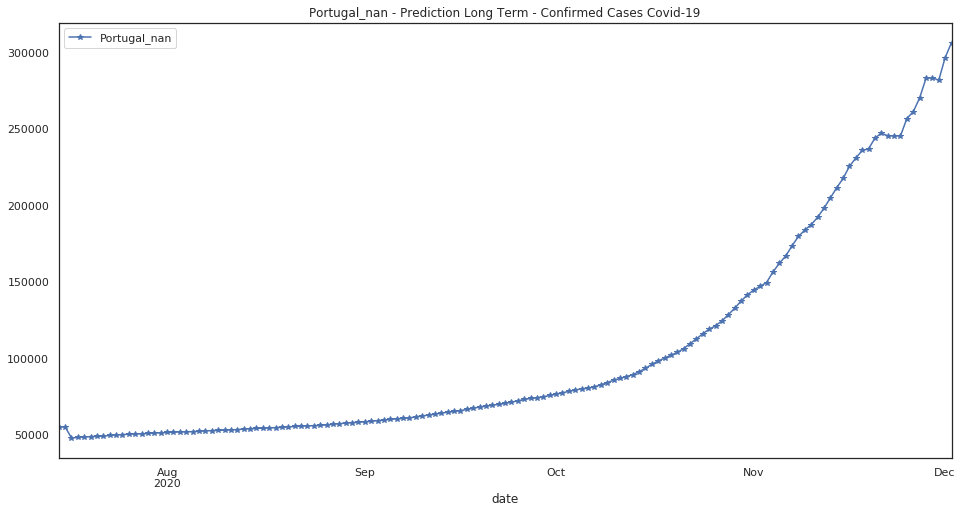

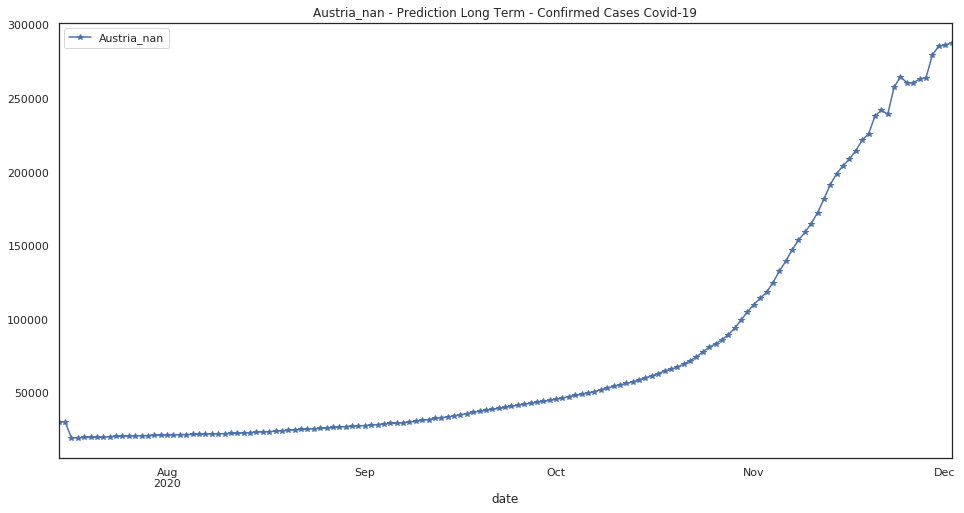

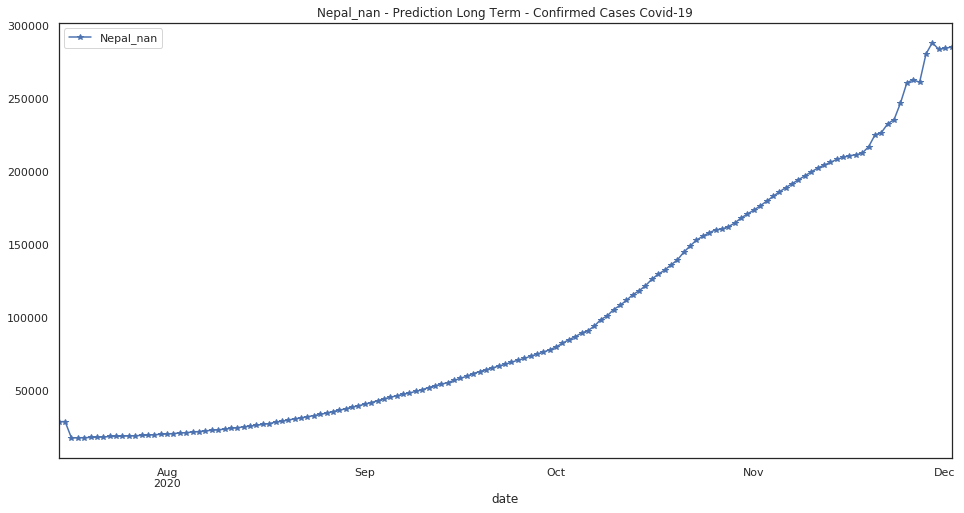

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

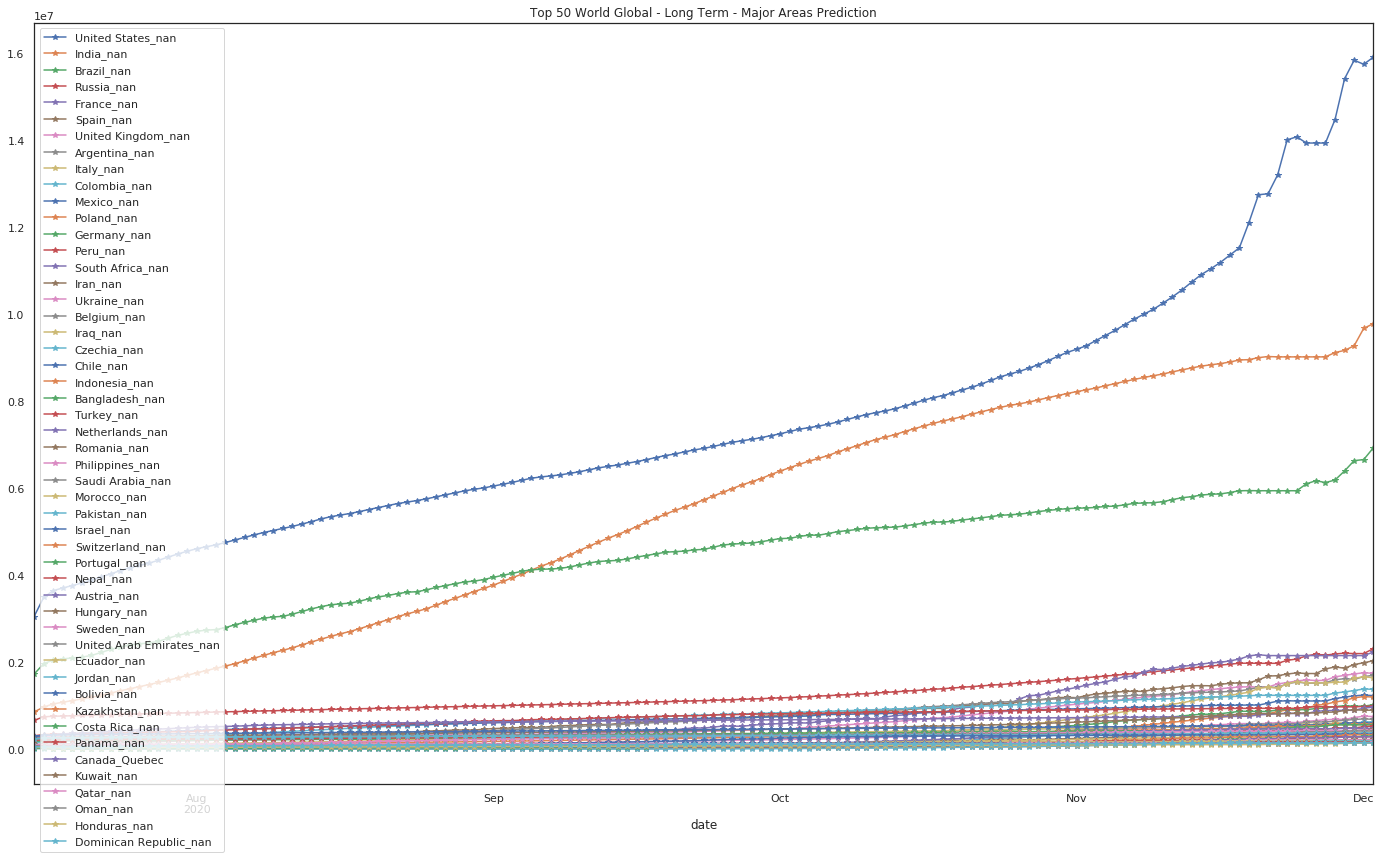

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

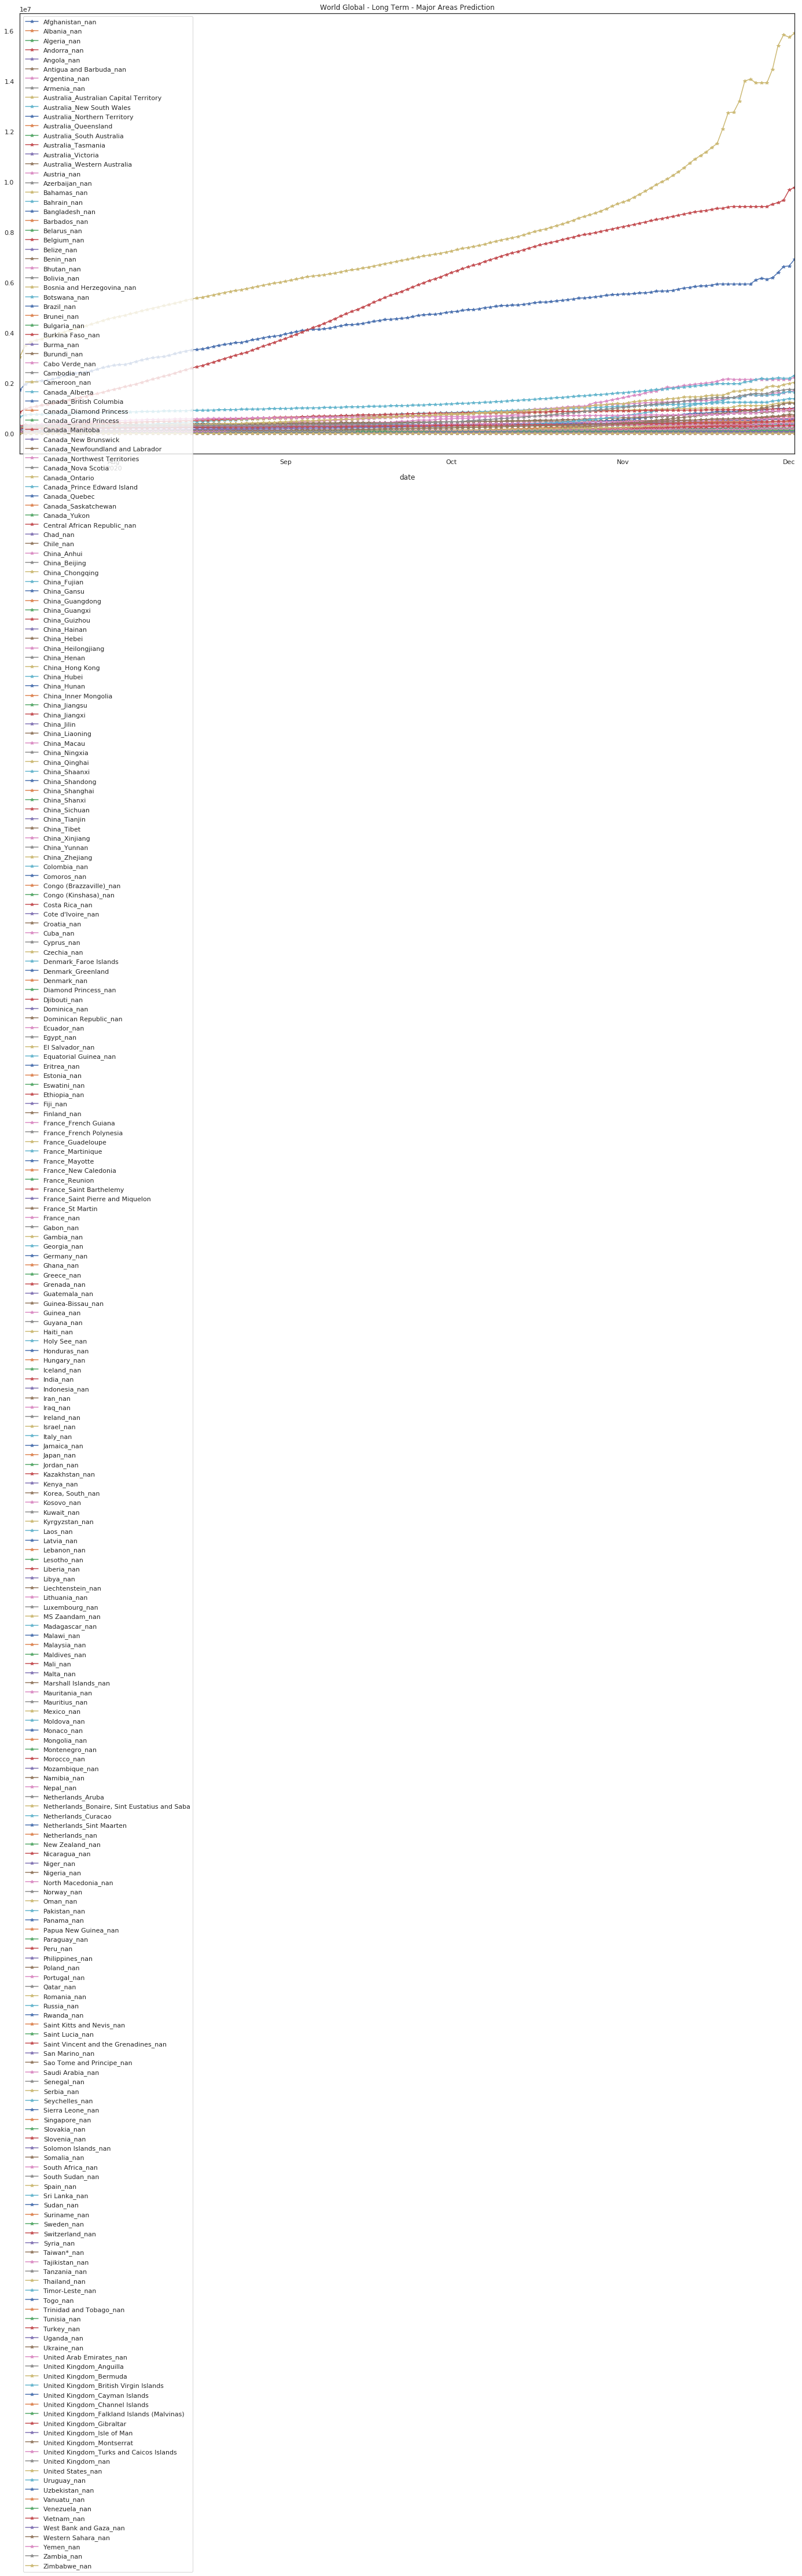

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38250.0       9324.0      43844.0       1124.0   
2020-08-30          38267.0       9451.0      44211.0       1221.0   
2020-08-31          38270.0       9552.0      44562.0       1267.0   
2020-09-01          38298.0       9608.0      44902.0       1176.0   
2020-09-02          38341.0       9775.0      45230.0       1230.0   
2020-09-03          38384.0       9855.0      45542.0       1199.0   
2020-09-04          38404.0       9982.0      45847.0       1309.0   
2020-09-05          38427.0      10110.0      46145.0       1215.0   
2020-09-06          38494.0      10251.0      46438.0       1301.0   
2020-09-07          38582.0      10387.0      46727.0       1341.0   
2020-09-08          38616.0      10541.0      47012.0       1261.0   
2020-09-09          38647.0      10701.0      47290.0       1385.0   
2020-09-10          38675.0      10855.0      47563.0       1301.0   
2020-09-11          38707.0      11013.0      47828.0       1430.0   
2020-09-12          38742.0      11176.0      48084.0       1344.0   
2020-09-13          38812.0      11343.0      48331.0       1442.0   
2020-09-14          38866.0      11509.0      48574.0       1523.0   
2020-09-15          38912.0      11667.0      48812.0       1438.0   
2020-09-16          38954.0      11827.0      49044.0       1604.0   
2020-09-17          38975.0      11968.0      49272.0       1483.0   
2020-09-18          38988.0      12104.0      49492.0       1653.0   
2020-09-19          39021.0      12258.0      49703.0       1564.0   
2020-09-20          39133.0      12390.0      49906.0       1681.0   
2020-09-21          39167.0      12538.0      50104.0       1783.0   
2020-09-22          39198.0      12680.0      50295.0       1681.0   
2020-09-23          39244.0      12819.0      50481.0       1865.0   
2020-09-24          39270.0      12958.0      50661.0       1753.0   
2020-09-25          39290.0      13072.0      50836.0       1927.0   
2020-09-26          39298.0      13191.0      50997.0       1836.0   
2020-09-27          39330.0      13308.0      51151.0       1930.0   
...                     ...          ...          ...          ...   
2020-11-03          41816.0      21867.0      59036.0       4888.0   
2020-11-04          41906.0      22243.0      59569.0       4910.0   
2020-11-05          42023.0      22660.0      60204.0       5045.0   
2020-11-06          42071.0      23137.0      60841.0       5135.0   
2020-11-07          42132.0      23615.0      61430.0       5135.0   
2020-11-08          42189.0      24123.0      62090.0       5319.0   
2020-11-09          42375.0      24651.0      62743.0       5383.0   
2020-11-10          42536.0      25210.0      63485.0       5437.0   
2020-11-11          42688.0      25720.0      64296.0       5477.0   
2020-11-12          42871.0      26165.0      65147.0       5567.0   
2020-11-13          43045.0      26673.0      66015.0       5616.0   
2020-11-14          43127.0      27177.0      66865.0       5725.0   
2020-11-15          43321.0      27757.0      67725.0       5725.0   
2020-11-16          43483.0      28347.0      68632.0       5872.0   
2020-11-17          43702.0      29032.0      69628.0       5914.0   
2020-11-18          43922.0      29725.0      70669.0       5951.0   
2020-11-19          45017.0      29837.0      70808.0       6018.0   
2020-11-20          45316.0      29965.0      73208.0       6199.0   
2020-11-21          45398.0      29952.0      73780.0       6516.0   
2020-11-22          46508.0      31357.0      77393.0       6567.0   
2020-11-23          46631.0      31668.0      78301.0       6567.0   
2020-11-24          46683.0      32195.0      78577.0       6868.0   
2020-11-25          46679.0      32261.0      78722.0       6868.0   
2020-11-26          46682.0      32287.0      78689.0       7225.0   
2020-11-27

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
245                             Timor-Leste_nan  -8.874217  125.727539   
246                                    Togo_nan   8.619500    0.824800   
247                     Trinidad and Tobago_nan  10.691800  -61.222500   
248                                 Tunisia_nan  33.886917    9.537499   
249                                  Turkey_nan  38.963700   35.243300   
250                           United States_nan  40.000000 -100.000000   
251                                  Uganda_nan   1.373333   32.290275   
252                                 Ukraine_nan  48.379400   31.165600   
253                    United Arab Emirates_nan  23.424076   53.847818   
254                     United Kingdom_Anguilla  18.220600  -63.068600   
255                      United Kingdom_Bermuda  32.307800  -64.750500   
256       United Kingdom_British Virgin Islands  18.420700  -64.640000   
257               United Kingdom_Cayman Islands  19.313300  -81.254600   
258              United Kingdom_Channel Islands  49.372300   -2.364400   
259  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
260                    United Kingdom_Gibraltar  36.140800   -5.353600   
261                  United Kingdom_Isle of Man  54.236100   -4.548100   
262                   United Kingdom_Montserrat  16.742498  -62.187366   
263     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
264                          United Kingdom_nan  55.378100   -3.436000   
265                                 Uruguay_nan -32.522800  -55.765800   
266                              Uzbekistan_nan  41.377491   64.585262   
267                                 Vanuatu_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      23               Belgium_nan  50.833300    4.469936   
4      27               Bolivia_nan -16.290200  -63.588700   
5      30                Brazil_nan -14.235000  -51.925300   
6      52             Canada_Quebec  52.939900  -73.549100   
7      57                 Chile_nan -35.675100  -71.543000   
8      91              Colombia_nan   4.570900  -74.297300   
9      95            Costa Rica_nan   9.748900  -83.753400   
10    100               Czechia_nan  49.817500   15.473000   
11    107    Dominican Republic_nan  18.735700  -70.162700   
12    108               Ecuador_nan  -1.831200  -78.183400   
13    128                France_nan  46.227600    2.213700   
14    133               Germany_nan  51.165691   10.451526   
15    143              Honduras_nan  15.200000  -86.241900   
16    144              Honduras_nan  15.200000  -86.241900   
17    145               Hungary_nan  47.162500   19.503300   
18    147                 India_nan  20.593684   78.962880   
19    148             Indonesia_nan  -0.789300  113.921300   
20    149                  Iran_nan  32.427908   53.688046   
21    150                  Iraq_nan  33.223191   43.679291   
22    152                Israel_nan  31.046051   34.851612   
23    153                Israel_nan  31.046051   34.851612   
24    154                 Italy_nan  41.871940   12.567380   
25    157                Jordan_nan  31.240000   36.510000   
26    158            Kazakhstan_nan  48.019600   66.923700   
27    162                Kuwait_nan  29.311660   47.481766   
28    184                Mexico_nan  23.634500 -102.552800   
29    189               Morocco_nan  31.791700   -7.092600   
30    192                 Nepal_nan  28.166700   84.250000   
31    197           Netherlands_nan  52.132600    5.291300   
32    204                  Oman_nan  21.512583   55.923255   
33    205              Pakistan_nan  30.375300   69.345100   
34    206                Panama_nan   8.538000  -80.782100   
35    209                  Peru_nan  -9.190000  -75.015200   
36    210           Philippines_nan  12.879721  121.774017   
37    211                Poland_nan  51.919400   19.145100   
38    212              Portugal_nan  39.399900   -8.224500   
39    213                 Qatar_nan  25.354800   51.183900   
40    214               Romania_nan  45.943200   24.966800   
41    215                Russia_nan  61.524010  105.318756   
42    222          Saudi Arabia_nan  23.885942   45.079162   
43    232          South Africa_nan -30.559500   22.937500   
44    234                 Spain_nan  40.463667   -3.749220   
45    238                Sweden_nan  60.128161   18.643501   
46    239           Switzerland_nan  46.818200    8.227500   
47    249                Turkey_nan  38.963700   35.243300   
48    250         United States_nan  40.000000 -100.000000   
49    252               Ukraine_nan  48.379400   31.165600   
50    253  United Arab Emirates_nan  23.424076   53.847818   
51    264        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              110235.0             113401.0             118206.0   
1               30170.0              30271.0              19270.0   
2              181991.0             193590.0             198406.0   
3               68220.0              68538.0              63238.0   
4               58947.0              60634.0              54849.0   
5             1725273.0            1966748.0            2051285.0   
6               62986.0              63110.0              57001.0   
7              293062.0             321205.0             325329.0   
8              157255.0             165169.0             181401.0   
9               21320.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()